# Tech Challenge - Fase 2


**GRUPO 8**

* Ana Carolina da Silva Carriel RM: 352918
* Gabriel Madeira Menacho       RM: 357318
* Lucas Sutil da Silva          RM: 357431
* Salomão José Freitas Bonilha  RM: 357058
* William de Araujo Almeida     RM: 357057

O comando a seguir baixa as bibliotecas nas versões que foram usadas neste projeto. Caso queira executar o notebook, é importante criar um virtualenv no seu ambiente. 
Na documentação oficial do Python, segue o passo a passo:
https://docs.python.org/pt-br/3/library/venv.html

**O problema**

Imagine que você foi escalado para um time de investimentos e precisará
realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para
criar uma série temporal e prever diariamente o fechamento da base.
Para isso utilize a base de dados contida no site da investing
(https://br.investing.com/indices/bovespa-historical-data) e selecione o período
“diário”, com o intervalo de tempo que achar adequado.
Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%).


**Início do trabalho:**

In [928]:
!pip install -r requirements.txt

## Importando as bibliotecas

In [929]:
import arch
import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import yfinance as yf
from prophet import Prophet
import scipy.stats as stats
from termcolor import colored
from matplotlib import rcParams
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

## Tabela de Utilidades das Bibliotecas Importadas

| Biblioteca | Descrição | Aplicações em Séries Temporais |
|---|---|---|
| **arch** | Modelagem de volatilidade condicional. Permite estimar modelos ARCH e GARCH para capturar a heterocedasticidade condicional presente em muitas séries financeiras. | Modelagem de risco, previsão de volatilidade. |
| **holidays** | Identificação de feriados. Útil para ajustar modelos de séries temporais, considerando os efeitos de feriados sobre a demanda ou preços. | Pré-processamento de dados, ajuste sazonal. |
| **numpy** | Computação numérica em Python. Essencial para operações com arrays, matrizes e funções matemáticas. | Cálculos numéricos, manipulação de dados. |
| **pandas** | Estrutura de dados para análise de dados. Permite criar e manipular DataFrames e Series, ideais para séries temporais. | Leitura, limpeza e transformação de dados, criação de índices de tempo. |
| **seaborn** | Visualização de dados estatísticos. Cria gráficos informativos e elegantes para explorar séries temporais. | Visualização de séries temporais, identificação de padrões, análise exploratória. |
| **xgboost** | Algoritmos de boosting baseados em árvores. Pode ser utilizado para previsão de séries temporais, especialmente quando há múltiplas variáveis explicativas. | Previsão, classificação. |
| **yfinance** | Download de dados financeiros. Permite obter cotações históricas de ações, índices e outras ativos financeiros. | Obtenção de dados para análise de séries temporais financeiras. |
| **Prophet** | Previsão probabilística. Especializada em séries temporais com componentes de tendência, sazonalidade e feriados. | Previsão de séries temporais com alta precisão e interpretabilidade. |
| **scipy.stats** | Estatística. Oferece uma ampla gama de testes estatísticos e distribuições de probabilidade. | Testes de hipóteses, análise de resíduos. |
| **termcolor** | Cores no terminal. Melhora a visualização de resultados em consoles. | Formatação de saída para melhor visualização. |
| **matplotlib** | Visualização de dados. Cria gráficos personalizados e interativos. | Criação de gráficos de séries temporais, análise exploratória. |
| **prettytable** | Tabelas ASCII. Formata dados em tabelas para melhor legibilidade. | Apresentação de resultados em formato tabular. |
| **sklearn.model_selection** | Divisão de dados. Separa dados em conjuntos de treinamento e teste para avaliação de modelos. | Avaliação de modelos de previsão. |
| **statsmodels.tsa.stattools** | Testes de raiz unitária. Verifica se uma série temporal é estacionária. | Análise de estacionariedade, seleção de modelos. |
| **statsmodels.tsa.statespace.sarimax** | Modelos SARIMA. Modelos lineares para séries temporais com componentes autoregressivos, de média móvel, sazonalidade e tendência. | Modelagem e previsão de séries temporais. |
| **statsmodels.tsa.seasonal** | Decomposição sazonal. Separa uma série temporal em componentes de tendência, sazonalidade e resíduos. | Análise de componentes de séries temporais. |
| **statsmodels.graphics.tsaplots** | Gráficos de séries temporais. Cria gráficos de autocorrelação e autocorrelação parcial. | Análise de autocorrelação, identificação de modelos ARIMA. |
| **sklearn.metrics** | Métricas de avaliação. Calcula métricas como MAE, RMSE e MAPE para avaliar a precisão de modelos. | Avaliação de modelos de previsão. |


## Definições Padrões para uso do matplotlib

In [930]:
rcParams['figure.figsize'] = 12, 5

A configuração acima foi definida para manter a escala de 12 por 5 para todos os plot do projeto.

# Importando os dados do IBOVESPA 

In [931]:
df = pd.read_csv("Ibovespa 2004 a 2024.csv", sep=',')
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%"
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%"
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%"
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%"
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%"
...,...,...,...,...,...,...,...
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%"
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%"
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%"
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%"


Os dados acima foram importados do site investing através do link (https://br.investing.com/indices/bovespa-historical-data). Conforme solicitado no tech challenge.

In [932]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%"
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%"
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%"
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%"
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%"


> Visualização das 5 primeiras linhas.

In [933]:
df.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%"
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%"
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%"
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%"
4999,02.01.2004,22.445,22.233,22.450,22.208,"136,42M","0,94%"


Visualização das 5 últimas linhas.

In [934]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


Ao analisar a visualização das informações da tabela acima, notamos que o campo 'data' está como 'object' em vez de 'datetime[ns]'.

In [935]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,67.437202,67.416755,68.087605,66.752167
std,28.529050,28.523403,28.714507,28.333544
min,17.604000,17.607000,18.387000,17.601000
25%,49.223250,49.220750,49.805000,48.578750
50%,60.956000,60.954500,61.551000,60.190500
75%,87.888000,87.850250,88.529500,86.841750
max,134.194000,134.194000,134.392000,133.832000


Visualização de dados estatísticos básicos da base.

In [936]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Visualização de dados nulos, foi identificado que a coluna Vol. tem um dado nulo, porém não iremos usar esse dado, então será ignorado.

# Tratamento de dados

#### A partir do dataframe DF foi criado uma 'Série Fechamento', o campo 'data' foi formatado para datetime e definido como index da série.

In [937]:
serie_fechamento = pd.Series(data=df['Último'].values, index=pd.to_datetime(df['Data'], format='%d.%m.%Y'))
serie_fechamento = serie_fechamento.sort_index(ascending=True)
serie_fechamento

Data
2004-01-02     22.445
2004-01-05     23.532
2004-01-06     23.576
2004-01-07     23.320
2004-01-08     23.717
               ...   
2024-03-06    128.890
2024-03-07    128.340
2024-03-08    127.071
2024-03-11    126.124
2024-03-12    127.668
Length: 5000, dtype: float64

# Avaliando os dados

#### Criamos uma função reutilizável para exibir séries. Ela permite personalizar o título e as legendas, que podem ser passadas como listas.

In [938]:
def plotarSerie(serie, titulo="Valores da bolsa de valores com base no fechamento diário", legendas=[]):
    serie.plot()    
    plt.title(titulo)
    plt.xlabel('Data')
    plt.grid(visible=True, linestyle='-', linewidth=0.7)
    plt.ylabel('Valor em Real (R$)')
    if legendas:
        plt.legend(labels=legendas, loc='best')

#### Feito um primeiro plot utilizando o método *'plotarSerie'(série, título, legendas)* para a 'Série Fechamento'.

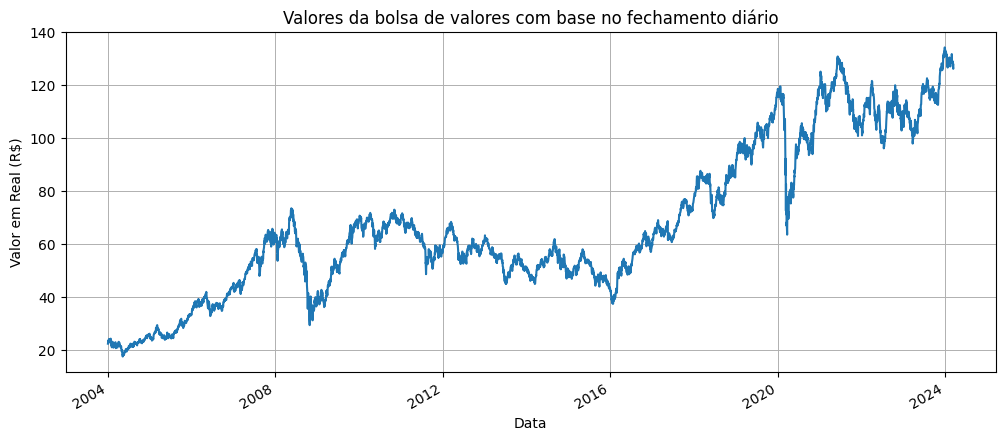

In [939]:
plotarSerie(serie_fechamento)

Já é possível notar, através do gráfico acima, que a série tem tendência de crescimento e, a princípio, não aparenta ser uma série estacionária, devido à sua crescente ao longo do tempo.

#### A seguir, foi desenvolvido um novo método que irá gerar gráficos da série temporal, incluindo a média móvel mensal, trimestral e anual.
> Obs: estamos considerando que os dias úteis do mês são 22 dias. Portanto, os números do metódo são baseado em dias úteis.


In [940]:
def plotar_medias_moveis(serie, titulo ='Fechamento da bolsa de valores com média móvel' ):
    dias_uteis = 22
    serie_media_movel_30 = serie.rolling(dias_uteis).mean()
    serie_media_movel_90 = serie.rolling(dias_uteis * 3).mean()
    serie_media_movel_anual = serie.rolling(dias_uteis * 12).mean()
    plotarSerie(serie)
    plotarSerie(serie_media_movel_30)
    plotarSerie(serie_media_movel_90)
    plotarSerie(serie_media_movel_anual, titulo ,['Valor Real','Média Móvel Mensal', 'Média Móvel Trimestral', 'Média Móvel Anual'])
    plt.show()

#### Utilizando o método descrito anteriormente, vamos plotar a série de fechamento para analisar visualmente sua tendência ao longo do tempo. Para isso, adicionaremos uma linha representando a média móvel de X períodos, o que nos permitirá identificar padrões e possíveis anomalias nos dados

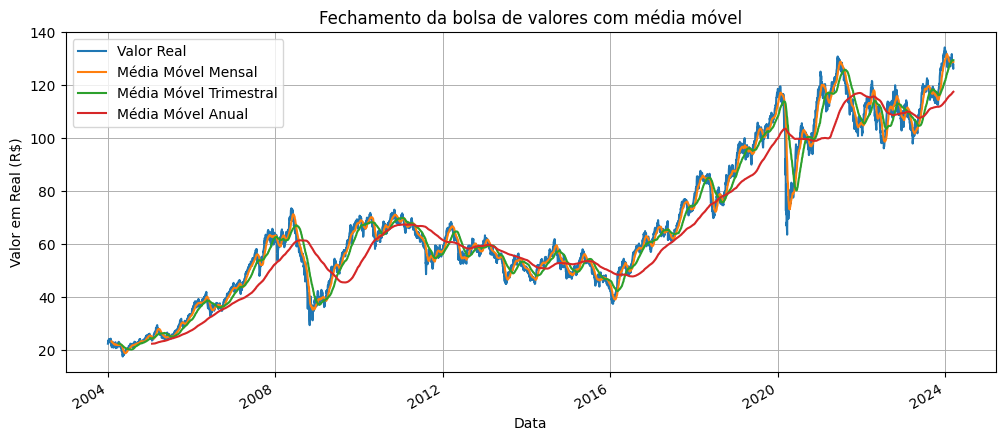

In [941]:
plotar_medias_moveis(serie_fechamento)

### Agora que já visualizamos os dados, vamos entender como está a distribuição dos dados

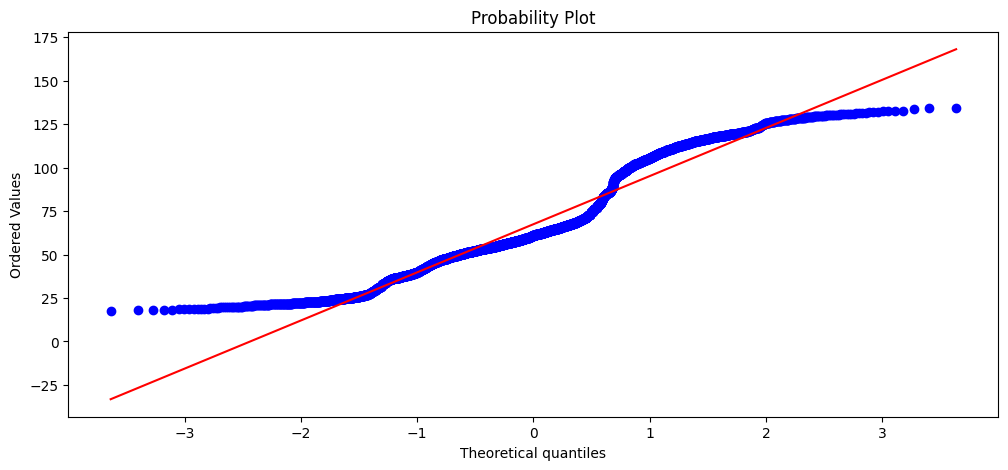

In [942]:
stats.probplot(serie_fechamento, dist='norm', plot=plt)
plt.show()

Avaliando a distribuição de dados com o Q-Q plot (quantile-quantile plot), é possível notar que a distribuição dos dados não está normalizada. O esperado é que os pontos azuis estivessem muito próximos da linha vermelha. Neste gráfico, os dados começam a se alinhar com a linha vermelha nos quantis intermediários, mas desviam-se nas caudas (extremos), indicando que a distribuição dos dados pode não ser perfeitamente normal.

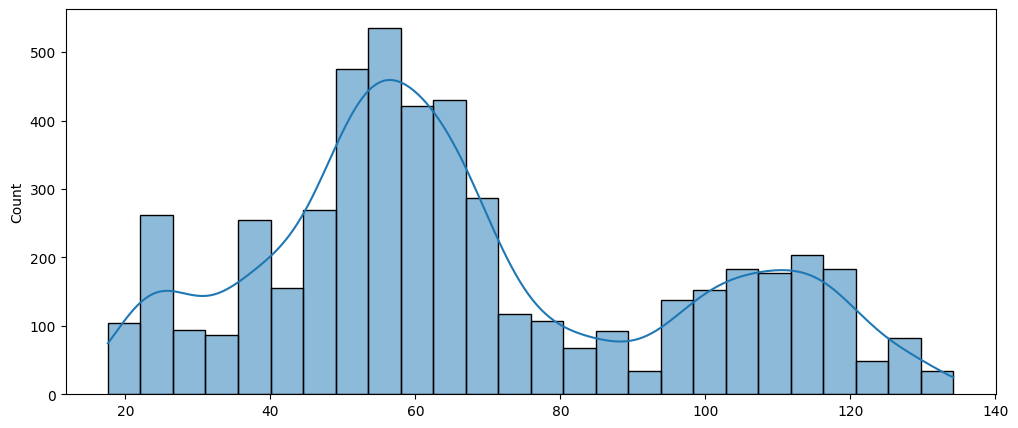

In [943]:
sns.histplot(serie_fechamento, kde=True)
plt.show()

Uma segunda forma de avaliação é utilizando o histograma. Nele, é possível visualizar que existem picos em torno dos 20, 60 e 110, o que aparenta indicar grupos distintos de dados ou várias distribuições sobrepostas, confirmando que os dados não seguem uma distribuição normal. Um gráfico de distribuição normal tem uma aparência em formato de sino.

## Teste de normalidade

Muitas vezes, as observações de um gráfico aparentam ter uma distribuição normal, mas isso não garante que os dados tenham uma distribuição normal. Para verificar a distribuição, podemos fazer o teste de **Shapiro Wilk**.

## Teste Shapiro-Wilk

### O que é o teste de Shapiro-Wilk?

    O teste de Shapiro-Wilk é uma ferramenta estatística utilizada para avaliar se um conjunto de dados se ajusta a uma distribuição normal. A distribuição normal, também conhecida como curva em forma de sino, é uma das distribuições mais comuns em estatística e é frequentemente utilizada em diversos modelos estatísticos.

#### Por que é importante testar a normalidade?

    Muitos testes estatísticos assumem que os dados seguem uma distribuição normal. Se essa premissa não for verdadeira, os resultados do teste podem ser enganosos. Ao realizar o teste de Shapiro-Wilk, você verifica se essa suposição é razoável para seus dados.

Critérios:

Nível de significância de 0,05 ou 5% (mais utilizado)

Valor de p < 0.05: Os dados provavelmente não são normalmente distribuídos.
Valor de p ≥ 0.05: Não há evidência suficiente para rejeitar a hipótese de normalidade.

### Abaixo, criamos um método que calcula, a partir de uma série, se a distribuição é normal ou não.

In [944]:
def validacao_distribuicao(serie):
    print(colored(':: Validação Distribuição (Shapiro-Wilk) ::', 'light_blue', attrs=["bold"]))
    e, p = stats.shapiro(serie)
    print(f'Estátistica do teste: {e}')
    print(f'p-valor: {p}')
    if p > e:
        print(colored('>> Distribuição Normal <<','green'))
    else:
        print(colored('Não há evidência suficiente para rejeitar a hipótese de normalidade','red'))


In [945]:
validacao_distribuicao(serie_fechamento)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.9403685462961359
p-valor: 6.571910093211889e-41
Não há evidência suficiente para rejeitar a hipótese de normalidade


Foi executado o teste de **Shapiro-Wilk** e constatou-se que não há uma distribuição normal. No entanto, podemos tentar buscar uma normalidade através da transformação logarítmica ou da transformação de raiz quadrada ou cúbica.


# Técnicas de Transformação para Normalização


Para transformar os dados visando uma normalização (ou aproximação de uma distribuição normal), você pode tentar diferentes técnicas de transformação. Aqui estão algumas abordagens comuns:


### 1. Transformação Logarítmica
Utilizada para reduzir a assimetria positiva (cauda longa à direita).

\[
    $y' = \log(y)$
\]

**Uso**: Quando os dados possuem muitos valores altos que puxam a média.

---

### 2. Transformação de Raiz Quadrada ou Cúbica
Suaviza variações em dados positivos e assimétricos.

\[
$y' = \sqrt{y}$
\]


## Aplicando a transformação com Logarítmica

In [946]:
serie_log = np.log(serie_fechamento)
serie_log.head()

Data
2004-01-02    3.111068
2004-01-05    3.158361
2004-01-06    3.160229
2004-01-07    3.149311
2004-01-08    3.166192
dtype: float64

[]

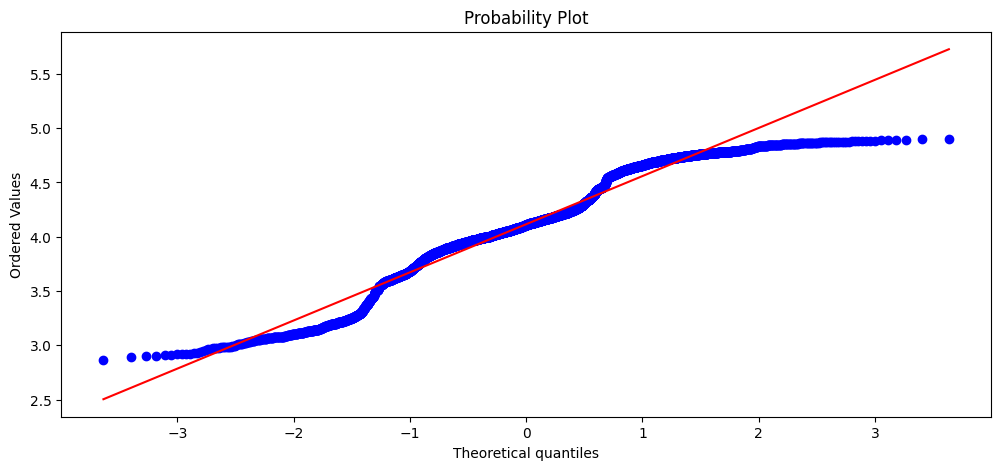

In [947]:
stats.probplot(serie_log, dist='norm', plot=plt)
plt.plot()

<Axes: ylabel='Count'>

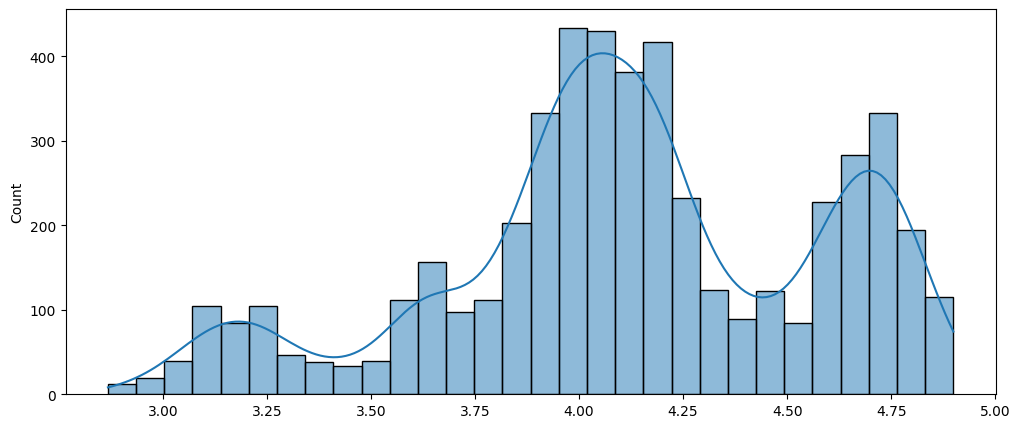

In [948]:
sns.histplot(serie_log, kde=True)

Após as transformações, a distribuição foi modificada, porém não obteve bons resultados, pois ainda não foi normalizada. Iremos aplicar a validação de Shapiro-Wilk para confirmação.

In [949]:
validacao_distribuicao(serie_log)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.9597856085568828
p-valor: 4.0735574502465716e-35
Não há evidência suficiente para rejeitar a hipótese de normalidade


     Mesmo após a transformação em logaritmo, não foi possível obter um bom resultado.

## Aplicando Transformação de Raiz Quadrada ou Cúbica

Iremos elevar ao cubo para tentar obter uma melhor distribuição. Usaremos o sign e abs para evitar o valores negativos.

In [950]:
serie_ao_cubo = np.sign(serie_fechamento)*abs(serie_fechamento)**(1/3)
serie_ao_cubo.head()

Data
2004-01-02    2.820806
2004-01-05    2.865627
2004-01-06    2.867412
2004-01-07    2.856995
2004-01-08    2.873117
dtype: float64

[]

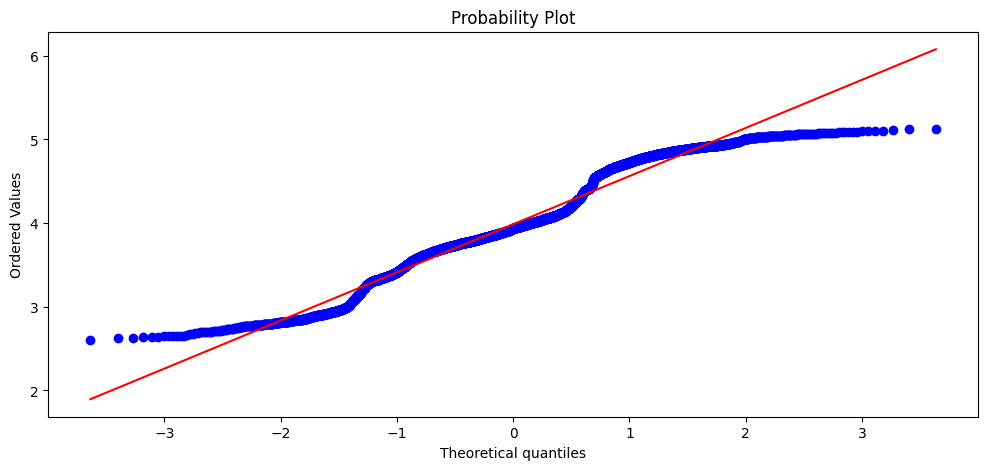

In [951]:
stats.probplot(serie_ao_cubo, dist='norm', plot=plt)
plt.plot()

[]

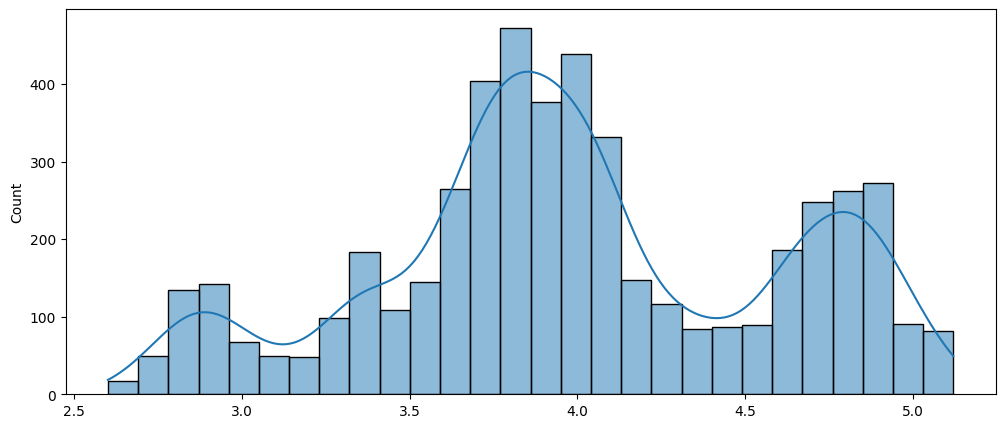

In [952]:
sns.histplot(serie_ao_cubo, kde=True)
plt.plot()

In [953]:
validacao_distribuicao(serie_ao_cubo)

:: Validação Distribuição (Shapiro-Wilk) ::
Estátistica do teste: 0.967088326048236
p-valor: 2.3955996920333463e-32
Não há evidência suficiente para rejeitar a hipótese de normalidade


 Mesmo fazendo a transformação para a série ao cubo, não foi possível obter a distribuição normal.

# Decomposição

#### Decompondo a 'Série Fechamento'

Vamos começar a avaliar os dados separadamente, com o objetivo de isolar os componentes para uma análise mais individual, o que ajudará a identificar o que está impulsionando o comportamento da série, como padrões sazonais ou uma tendência geral.

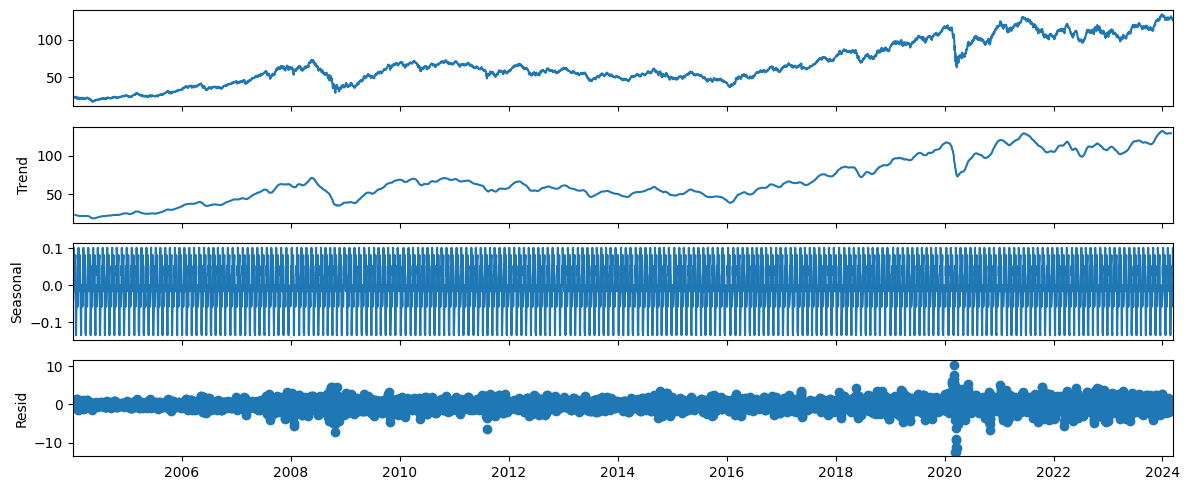

In [954]:
serie_decomposta = seasonal_decompose(serie_fechamento, period=22)
serie_decomposta.plot()
plt.tight_layout()

O gráfico acima demonstra uma tendência crescente ao longo do tempo, mas a sazonalidade fica difícil de avaliar. Portanto, vamos aumentar o período para melhorar a visualização da sazonalidade.

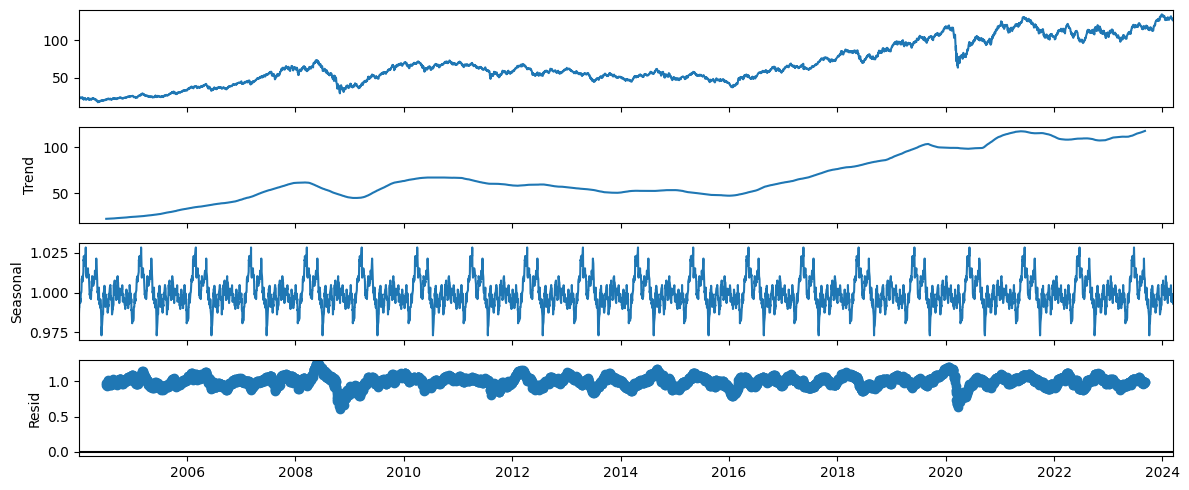

In [955]:
serie_decomposta = seasonal_decompose(serie_fechamento, model="multiplicative", period=252)
serie_decomposta.plot()
plt.tight_layout()

- Após aumentar o período, foi possível identificar melhor que existe uma sazonalidade entre os dados, e os resíduos também ficaram mais claros.
- Os resíduos representam o ruído da série temporal, ou seja, as variações que não são previsíveis com base nos componentes sistemáticos (tendência e sazonalidade, por exemplo). Essas flutuações podem ser devidas a eventos externos, fatores aleatórios ou variações de curto prazo.
- Tanto nos dados observados, na tendência e nos resíduos, é possível notar duas quedas: entre os anos de 2008-2009 e 2020.
- Essas quedas foram causadas por eventos que impactaram a economia mundial, sendo o primeiro deles em 2008, com a **Crise Financeira Global**. Esse evento teve um impacto profundo na economia global e nos mercados financeiros, levando a uma das maiores quedas nas bolsas de valores em todo o mundo desde a Grande Depressão de 1929.
- Em 2020, foi a **Pandemia da COVID-19**. A disseminação rápida do novo coronavírus (SARS-CoV-2) causou uma crise global de saúde pública, levando a grandes incertezas econômicas e a um colapso nos mercados financeiros. A crise desencadeada pela COVID-19 afetou praticamente todas as economias e setores ao redor do mundo.

Para uma observação mais próxima dos dias atuais, iremos analisar a sazonalidade nos últimos 500 dias, o que equivale a aproximadamente 2 anos.

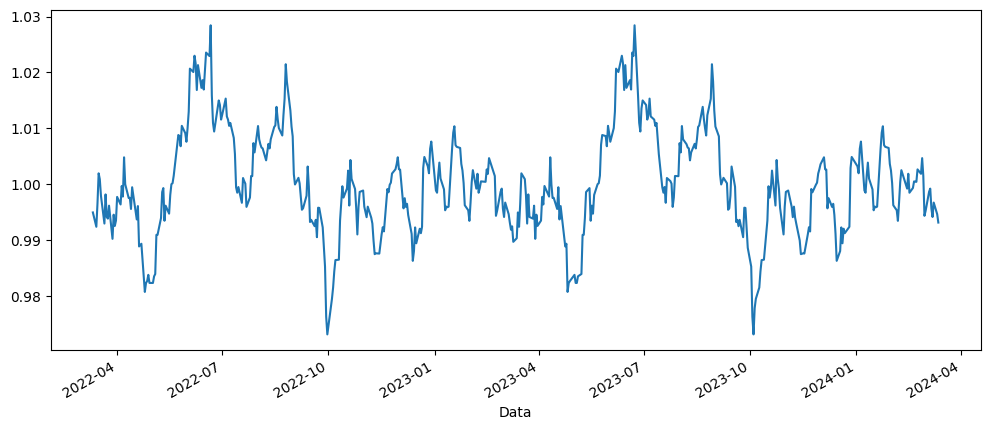

In [956]:
serie_decomposta.seasonal.iloc[-500:].plot()
plt.show()

Em 2 anos, é possível notar que existe uma sazonalidade no período observado.

# Estacionariedade

A **estacionariedade** é um conceito fundamental em séries temporais e análises estatísticas, pois tem implicações significativas para a modelagem e previsão de dados.

- Uma série temporal é dita estacionária se suas propriedades estatísticas, como média, variância e autocovariância, permanecem constantes ao longo do tempo. Isso significa que as flutuações e padrões observados em uma parte da série serão semelhantes em outras partes.
- Muitos modelos estatísticos pressupõem que os dados são estacionários, tendo, assim, uma previsão mais precisa sobre os dados.
- A **estacionariedade** permite detectar padrões, tendências e sazonalidades, que são essenciais para análise e previsão.

Através da decomposição, é possível notar que existe uma sazonalidade e uma tendência de crescimento, que aparenta não ser estacionária.

Para validar iremos um o test de KPSS e Dict Fuller

## Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

- O teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin) é um método estatístico para verificar a estacionaridade de séries temporais. Sua hipótese nula assume que a série é estacionária, enquanto a alternativa sugere que é não estacionária. O teste calcula um estatístico KPSS com base nos resíduos da série e compara com valores críticos para tomar decisões. Se o valor calculado for maior que o crítico, rejeita-se a estacionaridade. É amplamente utilizado em análises econômicas e financeiras para validar a adequação de modelos que presumem estacionaridade.

- Assumos então os seguintes critérios: 

> Ho = não é estacionário: estatística do teste > valor crítico

> Ha = é estacionário:  estatística do teste < valor crítico

#### Validação KPSS

Para facilitar o reuso, criamos um método que valida se a série é ou não estacionária e exibe os valores estatísticos e críticos do teste.

In [957]:
def validacao_kpss(serie):
    print(colored(':: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::', 'light_blue', attrs=["bold"]))
    resultado = kpss(serie)
    estatistica_teste = resultado[0]
    p_valor = resultado[1]
    valores_criticos  = resultado[3]
    percentil_referencia = '5%'

    print(f'Estatística do teste: {estatistica_teste:.4f}')
    print(f'p-valor {p_valor:.4f}')
    print('Valores Críticos:')
    table = PrettyTable(['Criticidade', 'Valor'])

    for chave, valor in valores_criticos.items():
        table.add_row([chave, valor])
    
    print(table)

    if estatistica_teste > valores_criticos[percentil_referencia]:
        print(colored('>> Série não estacionária <<', 'red'))
    else:
        print(colored('>> Série estacionária <<', 'green'))


#### Aplicando a validação KPSS

In [958]:
validacao_kpss(serie_fechamento)

:: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::
Estatística do teste: 8.9275
p-valor 0.0100
Valores Críticos:
+-------------+-------+
| Criticidade | Valor |
+-------------+-------+
|     10%     | 0.347 |
|      5%     | 0.463 |
|     2.5%    | 0.574 |
|      1%     | 0.739 |
+-------------+-------+
>> Série não estacionária <<


C:\Users\Will\AppData\Local\Temp\ipykernel_19576\3656016591.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado = kpss(serie)


- Na aplicação da 'Série Fechamento', foi identificado que ela não é estacionária, pois o valor do estatístico é maior que o valor crítico.

### Teste ADF (Dickey-Fuller)

* O teste de Dickey-Fuller é uma ferramenta estatística usada para verificar se uma série temporal possui raiz unitária, ou seja, se ela é estacionária. 
* A estacionariedade é importante para a aplicação de muitos modelos econométricos. O teste compara uma estatística calculada com um valor crítico. Se a estatística for menor que o valor crítico, rejeitamos a hipótese de raiz unitária e concluímos que a série é estacionária. 
* O teste de Dickey-Fuller aumentado (ADF) é a versão mais comum e inclui termos de defasagem para capturar a autocorrelação. A não estacionariedade pode levar a resultados enganosos em modelos econométricos e comprometer a qualidade das previsões.


> Se a estatística de teste for menor que o valor crítico, rejeitamos a hipótese nula e concluímos que a série é estacionária.

> Se a estatística de teste for maior ou igual ao valor crítico, não rejeitamos a hipótese nula e concluímos que a série pode ter raiz unitária (ou seja, não há evidências suficientes para afirmar que ela é estacionária).

Usaremos como valor de referência 5%

Resumo: 
- p-valor > 0.05  
    - Se p-valor for maior que o valor de referência: Não rejeitar a Hipótese Nula: a série não é estacionária 
- p-valor < 0.05
    - se p-valor for menor que o valor de referência: Rejeitar a Hipótese Nula: a série é estacionária

In [959]:
def validacao_adfuller(serie):
  print(colored(':: Validação ADF (Dickey-Fuller) ::', 'light_blue', attrs=["bold"]))
  result_adf = adfuller(serie)
  statistic_value = result_adf[0]
  p_value = result_adf[1]
  critical_values =  result_adf[4]
  valor_referencia = 0.05

  print(f"ADF Statistic: {statistic_value}")
  print(f'Valor-p do Teste ADF: {p_value}')

  table = PrettyTable(['Criticidade','Valor'])
  for key, value in critical_values.items():
    table.add_row([key, value])

  print(table)

  if p_value > valor_referencia:
    print(colored('Não rejeitar a Hipótese Nula: a série não é estacionária\n','red'))
  else:
    print(colored('Rejeitar a Hipótese Nula: a série é estacionária\n','green'))

In [960]:
validacao_adfuller(serie_fechamento)

:: Validação ADF (Dickey-Fuller) ::
ADF Statistic: -1.0890536425095538
Valor-p do Teste ADF: 0.7194173863860649
+-------------+---------------------+
| Criticidade |        Valor        |
+-------------+---------------------+
|      1%     |  -3.43166168173001  |
|      5%     | -2.8621196211801374 |
|     10%     | -2.5670785331097763 |
+-------------+---------------------+
Não rejeitar a Hipótese Nula: a série não é estacionária



Usamos o teste de ADF para validar se a série é ou não estacionária, e foi concluído que a série não é estacionária.

#### Avaliando a autocorrelação

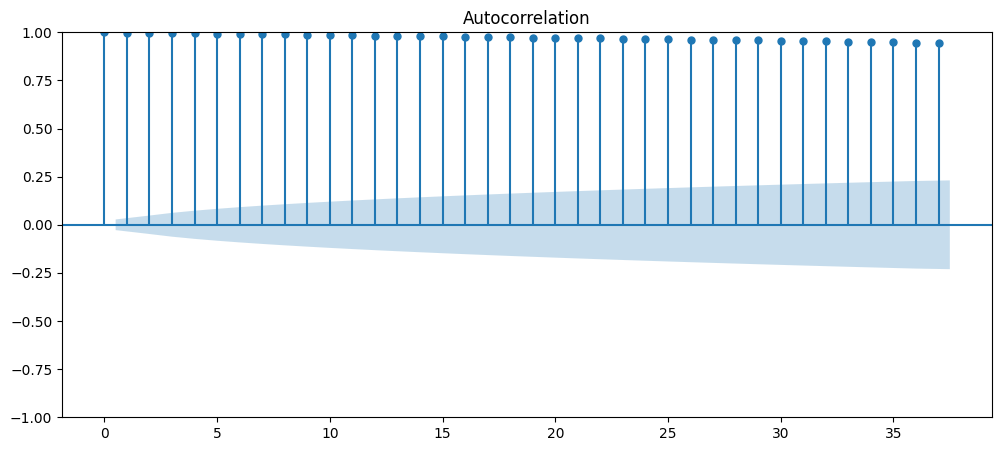

In [961]:
plot_acf(serie_fechamento)
plt.show()

As barras verticais mostram os valores de autocorrelação muito próximos de 1 para todos, exibindo um sinal claro de que a série não é estacionária. Isso demonstra um padrão de decaimento lento ou até mesmo a ausência de decaimento. Como a autocorrelação mantém um valor elevado, isso indica que existe uma forte dependência temporal entre os pontos da série.

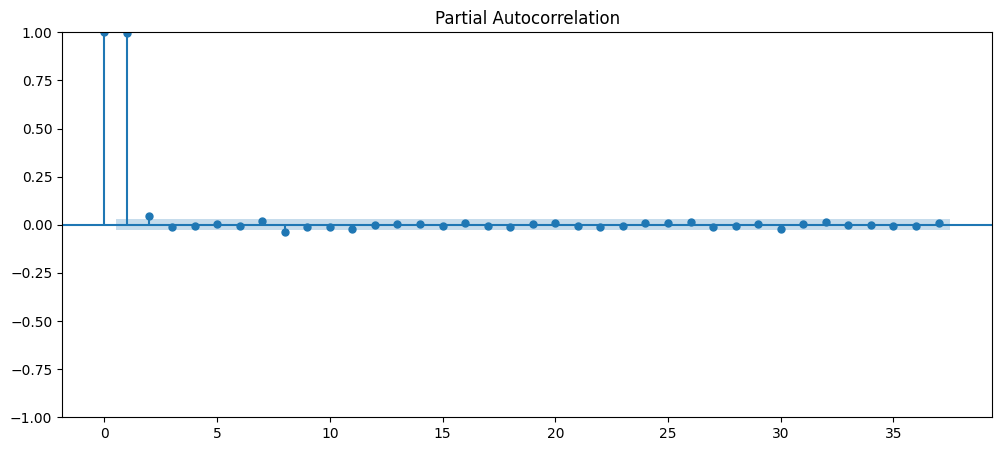

In [962]:
plot_pacf(serie_fechamento)
plt.show()

- A autocorrelação parcial mostra que o valor atual da série está fortemente relacionado ao valor anterior. Com essa informação, é possível notar que os valores mais distantes no passado têm pouca influência na previsão do valor atual.

  Após todas as análises, concluímos que a série não é estacionária e que precisamos transformá-la em estacionária para obter um melhor aproveitamento dos modelos que iremos criar. Portanto, iremos aplicar a técnica de diferenciação.

# Diferenciação

- A técnica de diferenciação é uma técnica utilizada para transformar uma série temporal não estacionária em uma série estacionária.
- Ela consiste em subtrair o valor de uma observação do valor da observação anterior. Essa operação remove tendências e sazonalidades presentes na série original, tornando-a mais adequada para a aplicação de modelos econométricos e de previsão. 
- Ao diferenciar uma série, estamos analisando a taxa de variação ao invés dos níveis absolutos dos dados.

#### Aplicando Diferenciação

In [963]:
serie_fechamento_diff = serie_fechamento.diff()
serie_fechamento_diff = serie_fechamento_diff.dropna()
serie_fechamento_diff

Data
2004-01-05    1.087
2004-01-06    0.044
2004-01-07   -0.256
2004-01-08    0.397
2004-01-09    0.200
              ...  
2024-03-06    0.792
2024-03-07   -0.550
2024-03-08   -1.269
2024-03-11   -0.947
2024-03-12    1.544
Length: 4999, dtype: float64

- Foi aplicada a diferenciação e excluída a primeira linha, que estava nula, justamente porque na diferenciação se perde o primeiro valor, pois ele não teve nenhum valor para comparar com o anterior, tornando-se nulo.

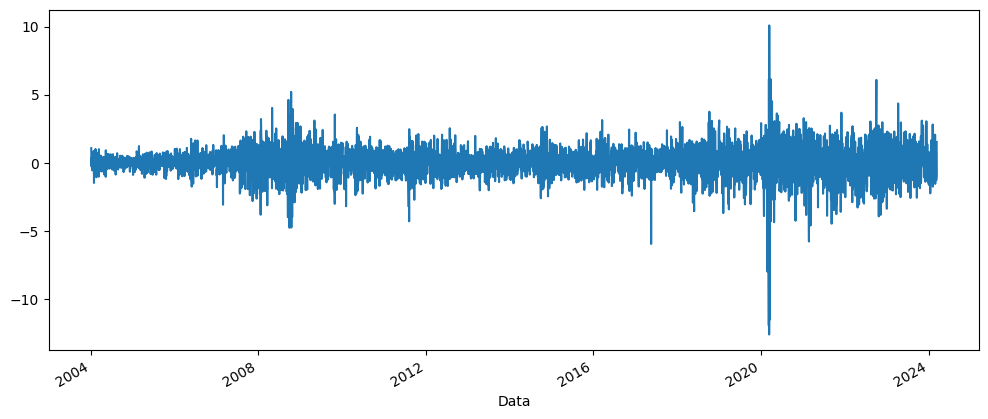

In [964]:
serie_fechamento_diff.plot()
plt.show()

- Após a transformação, percebemos que houve uma mudança no comportamento da série. É possível notar a ausência de tendência, o que significa que a média e a variância da série são constantes ao longo do tempo. Possivelmente, ela se transformou em uma série estacionária, mas, para isso, iremos aplicar novamente os testes KPSS e ADF para validar se realmente se tornou estacionária.

In [965]:
validacao_kpss(serie_fechamento_diff)

:: Validação KPSS (Kwiatkowski-Phillips-Schmidt-Shin) ::
Estatística do teste: 0.0475
p-valor 0.1000
Valores Críticos:
+-------------+-------+
| Criticidade | Valor |
+-------------+-------+
|     10%     | 0.347 |
|      5%     | 0.463 |
|     2.5%    | 0.574 |
|      1%     | 0.739 |
+-------------+-------+
>> Série estacionária <<


C:\Users\Will\AppData\Local\Temp\ipykernel_19576\3656016591.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  resultado = kpss(serie)


O Resultado da transformação foi positivo, o teste **KPSS** informa que conseguimos tranformar ela em estacionária.

In [966]:
validacao_adfuller(serie_fechamento_diff)

:: Validação ADF (Dickey-Fuller) ::
ADF Statistic: -19.48680292031839
Valor-p do Teste ADF: 0.0
+-------------+---------------------+
| Criticidade |        Valor        |
+-------------+---------------------+
|      1%     |  -3.43166168173001  |
|      5%     | -2.8621196211801374 |
|     10%     | -2.5670785331097763 |
+-------------+---------------------+
Rejeitar a Hipótese Nula: a série é estacionária



O Resultado da transformação foi positivo, o teste **ADF** informa que conseguimos tranformar ela em estacionária.

- Conseguimos através da diferenciação transformar a série em estacionária, agora podemos avaliar o comportamento da série novamente.

[]

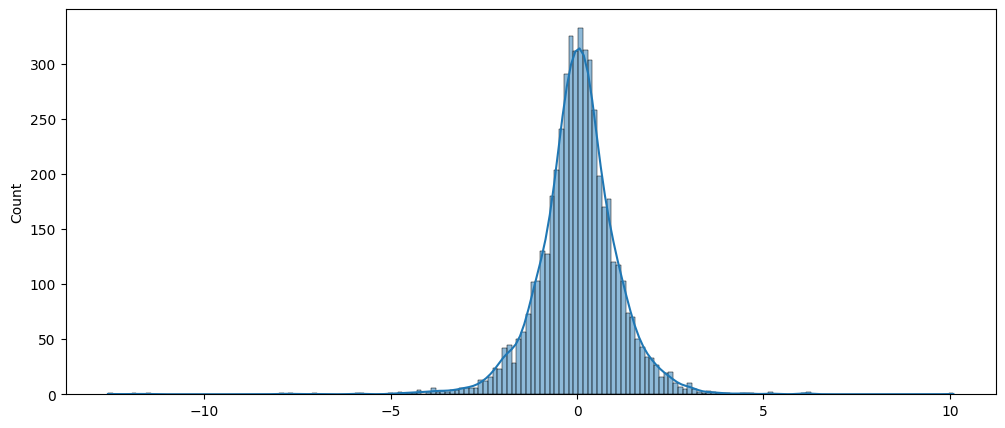

In [967]:
sns.histplot(serie_fechamento_diff, kde=True)
plt.plot()

Avaliando o histograma acima, é possível notar a diferença na série, mostrando que os dados estão mais centralizados próximos a zero, com formato de sino, indicando uma normalidade entre os dados, embora não perfeita.

# Decomposição da Série Diferencial

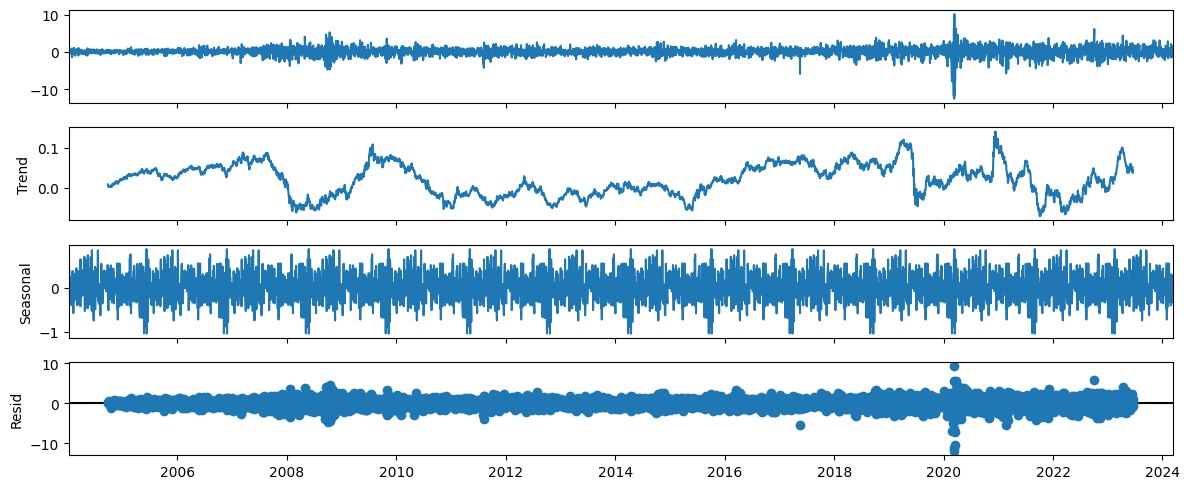

In [968]:
serie_diff_decomposta = seasonal_decompose(serie_fechamento_diff, period=365)
serie_diff_decomposta.plot()
plt.tight_layout()

- Após a transformação, também é possível notar que não há mais a tendência de alta e baixa, e que os resíduos estão aleatórios e sem padrões claros. No entanto, é possível observar que os anos de 2008-2009 e 2020 continuam a influenciar os gráficos de observação, tendência e resíduos.

##  Avaliação dos resíduos

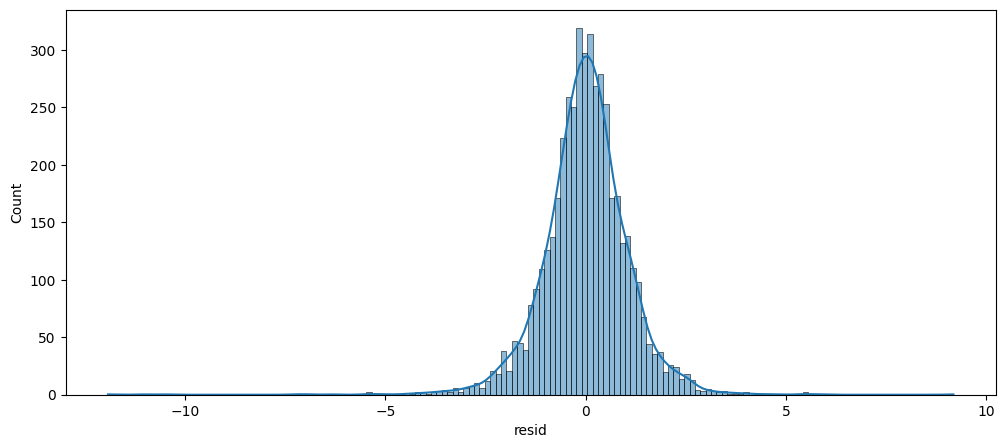

In [969]:
sns.histplot(serie_diff_decomposta.resid, kde=True)
plt.show()

- Conseguimos avaliar visualmente que os resíduos aparentam ter uma distribuição bem próxima do normal, com uma concentração de valores bem próximos de zero. No entanto, a cauda indica possíveis outliers.

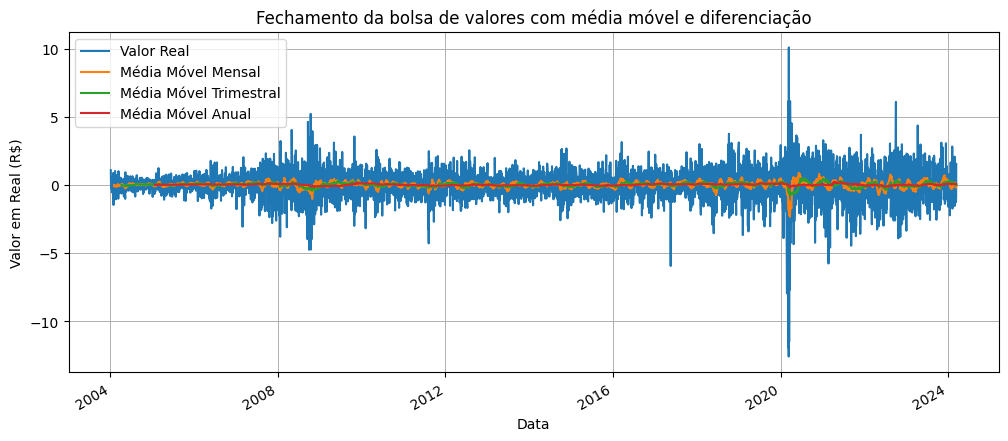

In [970]:
plotar_medias_moveis(serie_fechamento_diff, 'Fechamento da bolsa de valores com média móvel e diferenciação')

- Na imagem acima, conseguimos visualizar o valor real diferenciado e suas médias móveis mensal, trimestral e anual, onde ela demonstra ter se tornado estacionária, não apresentando evidências de tendências. A ausência de padrões sazonais nas médias móveis sugere também que a sazonalidade foi removida, e que a variabilidade da série parece ser constante ao longo do tempo.

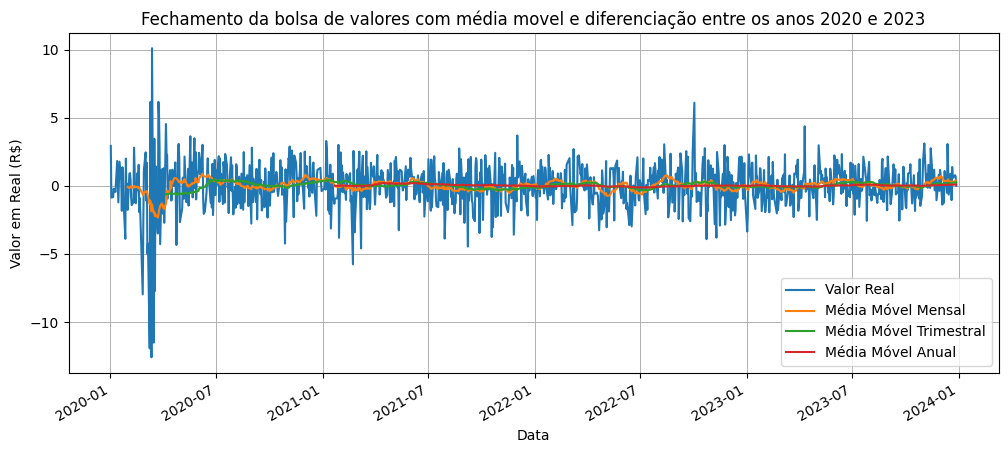

In [971]:
plotar_medias_moveis(serie_fechamento_diff.loc[pd.Timestamp('2020-01-02'):pd.Timestamp('2023-12-29')], 'Fechamento da bolsa de valores com média movel e diferenciação entre os anos 2020 e 2023')

- Na imagem acima, temos as mesmas características da imagem anterior; a diferença é que estamos vendo os últimos 4 anos, o que torna mais fácil a visualização e o entendimento do gráfico.

# Autocorrelação com diferenciação


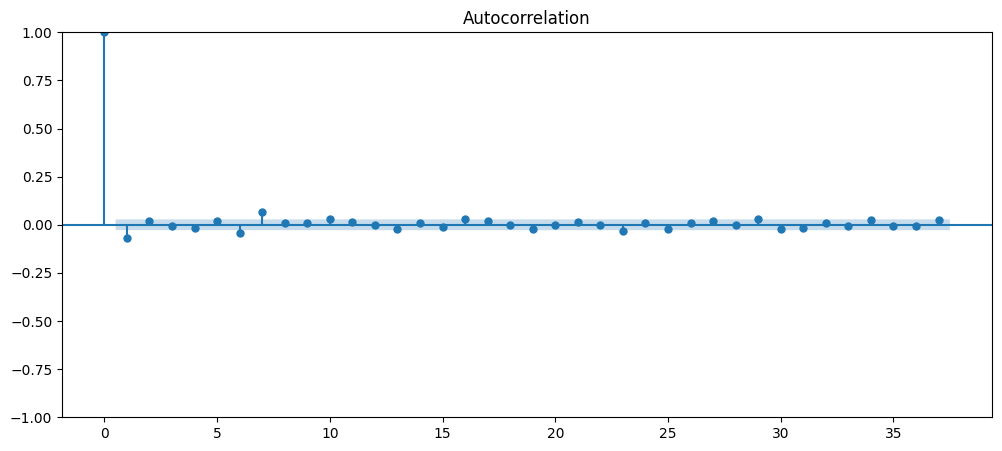

In [972]:
plot_acf(serie_fechamento_diff)
plt.show()

- A autocorrelação da diferenciação apresentou um resultado satisfatório, pois foi possível notar que, a partir do indicador 2, a correlação se manteve próxima ao intervalo de confiança, exceto por um ponto fora, porém aceitável.

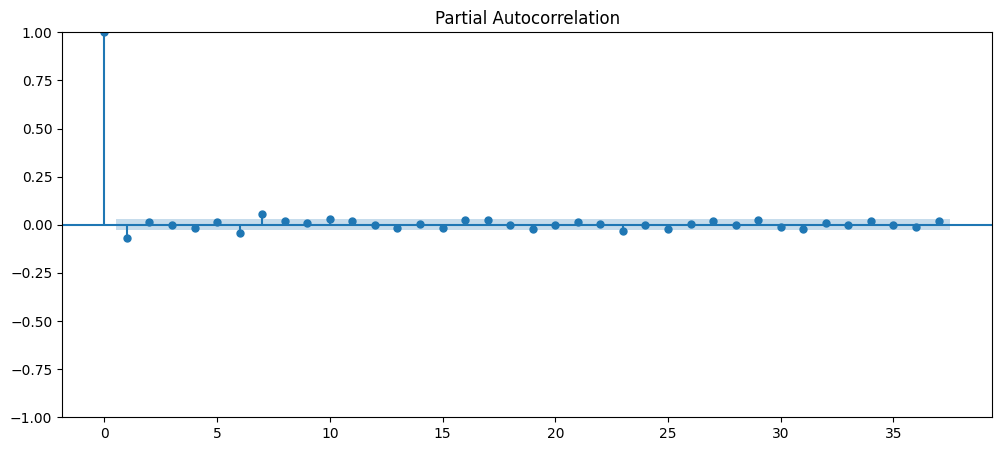

In [973]:
plot_pacf(serie_fechamento_diff)
plt.show()

A correlação parcial também teve bons resultados, considerando que, a partir do segundo ponto, se manteve dentro ou bem próxima do intervalo de confiança. Com esse resultado, já é possível utilizar um modelo ARIMA com ordem 2, baseado nessa análise.

# Aplicação do Modelo ARIMA

### AutoRegressive Integrated Moving Average (ARIMA)
*É um modelo estatístico amplamente utilizado para analisar e prever séries temporais. As letras que compõem essa sigla possuem significados específicos:*
* AR (AutoRegressiva): Indica que o valor da série em um determinado momento é uma função linear de seus valores anteriores. Ou seja, os valores passados influenciam os valores futuros.
* I (Integrada): Refere-se ao processo de diferenciação aplicado à série temporal. A diferenciação é uma técnica utilizada para tornar a série estacionária, removendo tendências ou sazonalidades.
* MA (Média Móvel): Indica que o valor da série em um determinado momento é uma função linear dos erros aleatórios (ruídos) ocorridos em momentos anteriores



*Um modelo ARIMA é representado por três números: ARIMA(p,d,q).*
* p: Ordem do processo autoregressivo. Indica o número de períodos anteriores que são usados para prever o valor atual.
* d: Grau de diferenciação. Indica o número de vezes que a série é diferenciada para torná-la estacionária.
* q: Ordem do processo de médias móveis. Indica o número de termos de erro anteriores que são incluídos no modelo.

- Considerando os valores encontrados nos resultados anteriores, iremos começar testando o modelo com os seguintes valores p = 2, d = 1, e q = 1

- sendo *p = 2*  que o valor atual vai depender dos 2 valores anteriores, *d = 1* porque usamos a diferenciação uma unica vez e  *q = 1*  que o erro atual depende do erro anterior

### Executando o Modelo ARIMA

In [974]:
p,d,q =  2,1,1
modelo_arima = SARIMAX(serie_fechamento_diff, order = (p,d,q), trend='c', enforce_stationarity=True)
resultado = modelo_arima.fit()
print(resultado.summary())

c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4999
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -7582.437
Date:                Sun, 13 Oct 2024   AIC                          15174.874
Time:                        17:26:03   BIC                          15207.458
Sample:                             0   HQIC                         15186.294
                               - 4999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.887e-07   1.14e-05     -0.025      0.980   -2.27e-05    2.21e-05
ar.L1         -0.0701      0.005    -12.783      0.000      -0.081      -0.059
ar.L2          0.0156      0.005      2.848      0.0

O IAC encontrado foi de 15174. Porém, tem alguns warning no qual podemos avaliar:
- Ele indica que o índice de data não tem uma frequência. Isso ocorre porque, na nossa série, temos alguns dias faltando, como feriados e finais de semana, o que impede que tenhamos todos os dias do ano e não permite definir uma frequência diária.

#### Prevendo 10 dias

In [975]:
data_inicial = '2024-03-12'
index = pd.date_range(start=data_inicial, periods=10)
forecast_arima = resultado.forecast(10)
forecast_arima
resultado_previsao_arima = pd.Series(data=forecast_arima.values, index=index)

c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- Usamos o método forecast para prever os próximos 10 dias.

[]

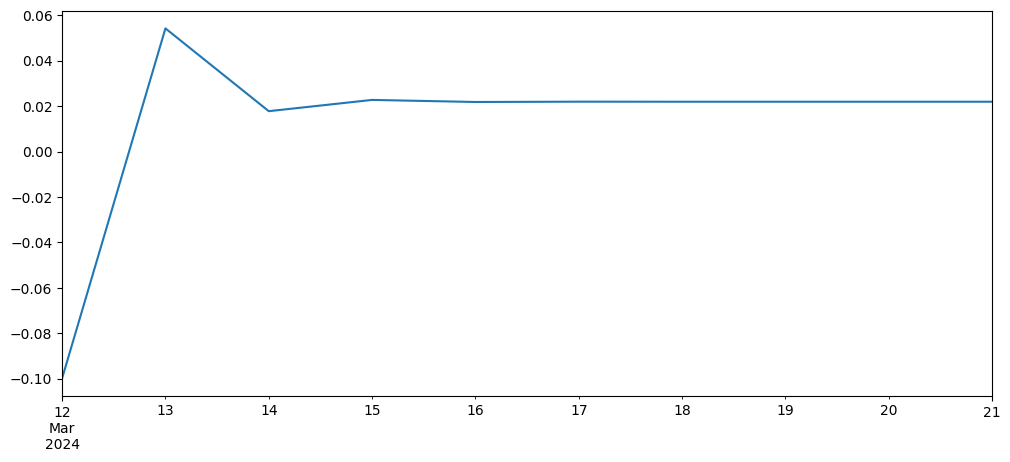

In [976]:
resultado_previsao_arima.plot()
plt.plot()

- A previsão conseguiu prever os 2 primeiros valores, mas, após isso, entrou em uma linha reta. Isso indica que o nosso modelo não está conseguindo prever muito bem com os nossos dados. Vamos aplicar o modelo GARCH para tentar melhorar os resultados.

#### Aplicando o Modelo GARCH

- (Heterocedasticidade Condicional AutoRegressiva Generalizada) é um modelo estatístico utilizado para modelar a volatilidade de séries temporais financeiras. Ele assume que a variância dos retornos de um ativo não é constante ao longo do tempo, mas sim dependente de suas próprias realizações passadas. Em outras palavras, o GARCH captura a ideia de que períodos de alta volatilidade tendem a ser seguidos por outros períodos de alta volatilidade, e o mesmo ocorre com períodos de baixa volatilidade.

Iremos usar o resíduo do resultado do modelo, assumindo que a média dos resíduos é zero. Vamos utilizar o 'vol' como 'GARCH', pois queremos usar um modelo GARCH para modelar a volatilidade dos resíduos, que é capaz de capturar a variância dos erros ao longo do tempo, utilizando os mesmos valores de p e q que foram usados no ARIMA.

In [977]:
resid = resultado.resid
model_garch = arch.arch_model(resid, mean='Zero', vol='GARCH', p=p, q=q).fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2724399038.7489057
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6681.804830235775
Iteration:      3,   Func. Count:     19,   Neg. LLF: 14997.142198901995
Iteration:      4,   Func. Count:     27,   Neg. LLF: 13167.812663297034
Iteration:      5,   Func. Count:     33,   Neg. LLF: 6662.010536888418
Iteration:      6,   Func. Count:     39,   Neg. LLF: 6647.681727479783
Iteration:      7,   Func. Count:     45,   Neg. LLF: 6716.470522062273
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6644.409986409801
Iteration:      9,   Func. Count:     58,   Neg. LLF: 6645.937750525545
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6643.752004420932
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6643.751983583872
Iteration:     12,   Func. Count:     73,   Neg. LLF: 6643.751981329142
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6643.751983583872
            Iterations: 1

Após sua finalização, iremos tentar prever novamente, só que agora para um período de 30 dias.

In [978]:
data_inicio, data_fim = '2024-03-12','2024-04-10'
forecast_arima = resultado.forecast(steps=30)
forecast_garch = model_garch.forecast(horizon=30)
forecast = forecast_arima + np.sqrt(forecast_garch.variance.values[-1, :]) * np.random.normal(size=30)
serie_prevista_garch = pd.Series(data=forecast.values, index=pd.date_range(data_inicio, data_fim))


c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- Fizemos novamente o forecast tanto do ARIMA quanto do GARCH e juntamos os valores em um único forecast, criando uma série prevista com GARCH.

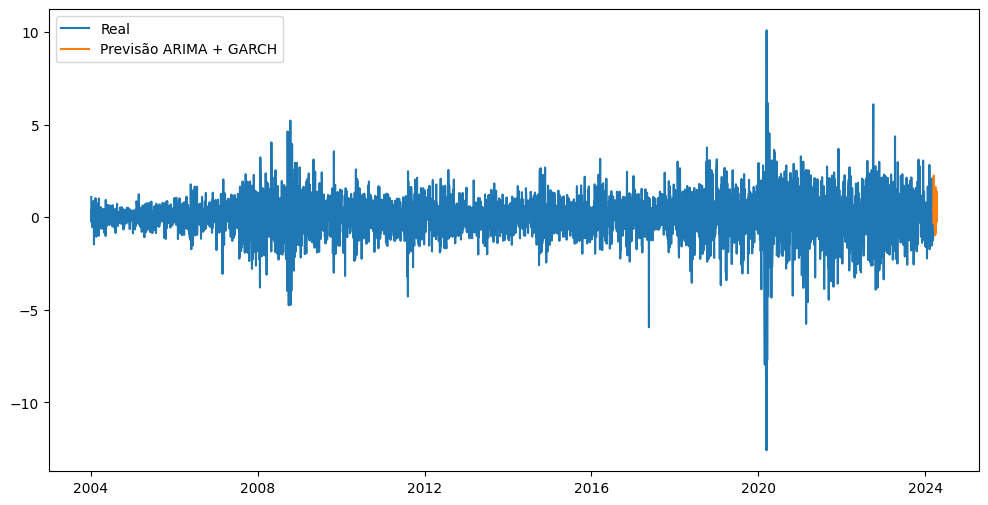

In [979]:
plt.figure(figsize=(12, 6))
plt.plot(serie_fechamento_diff, label='Real')
plt.plot(serie_prevista_garch, label='Previsão ARIMA + GARCH')
plt.legend()
plt.show()

- Fizemos o plot dos valores reais e previstos, e o resultado foi satisfatório. A seguir, veremos um pouco mais de perto como ficou a previsão.

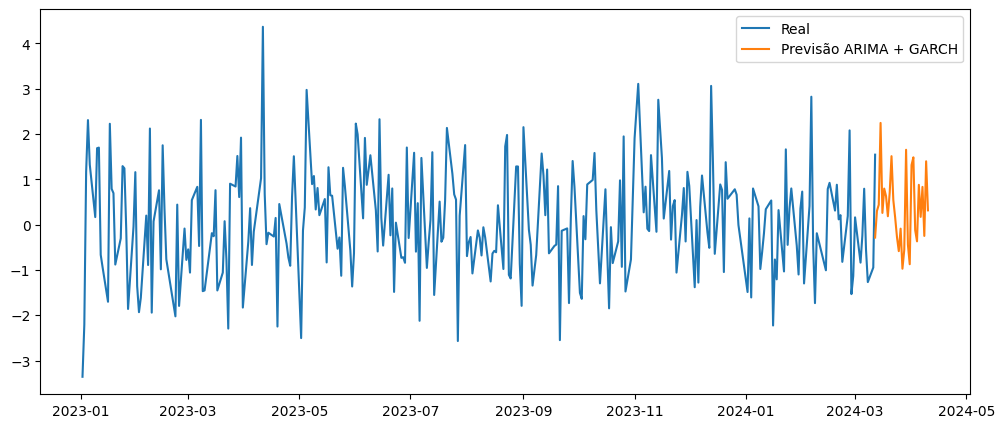

In [980]:
plt.plot(serie_fechamento_diff.loc[pd.Timestamp('2023-01-02'):pd.Timestamp('2024-03-12')], label='Real')
plt.plot(serie_prevista_garch, label='Previsão ARIMA + GARCH')
plt.legend()
plt.show()

Na imagem acima, é possível notar que a previsão conseguiu se manter adequada, seguindo conforme o esperado.

### Reversão da diferenciação da série prevista

Foi criado um metodo para reverter a diferenciação dos dados, utilizando o ultimo valor da serie real e aplicando a soma dos valores seguintes em toda a série

In [981]:
def reverter_diferenciacao(serie,serie_diferenciada):

    ultimo_valor = serie.iloc[-1]
    serie_normalizada = ultimo_valor + serie_diferenciada.cumsum()
    serie_normalizada

    return serie_normalizada    

In [982]:
previsao_normal = reverter_diferenciacao(serie_fechamento, serie_prevista_garch)
previsao_normal

2024-03-12    127.381820
2024-03-13    127.683129
2024-03-14    128.121345
2024-03-15    130.365814
2024-03-16    130.623857
2024-03-17    131.418689
2024-03-18    132.046652
2024-03-19    132.231264
2024-03-20    132.933399
2024-03-21    134.443989
2024-03-22    134.983250
2024-03-23    135.141817
2024-03-24    134.866318
2024-03-25    134.280570
2024-03-26    134.191240
2024-03-27    133.217616
2024-03-28    132.659374
2024-03-29    134.311428
2024-03-30    133.868421
2024-03-31    132.993743
2024-04-01    134.308969
2024-04-02    135.794079
2024-04-03    135.668879
2024-04-04    135.299479
2024-04-05    136.177489
2024-04-06    136.348032
2024-04-07    137.180721
2024-04-08    136.930972
2024-04-09    138.328749
2024-04-10    138.643345
Freq: D, dtype: float64

Os dados foram normalizados voltando à origem dos valores reais

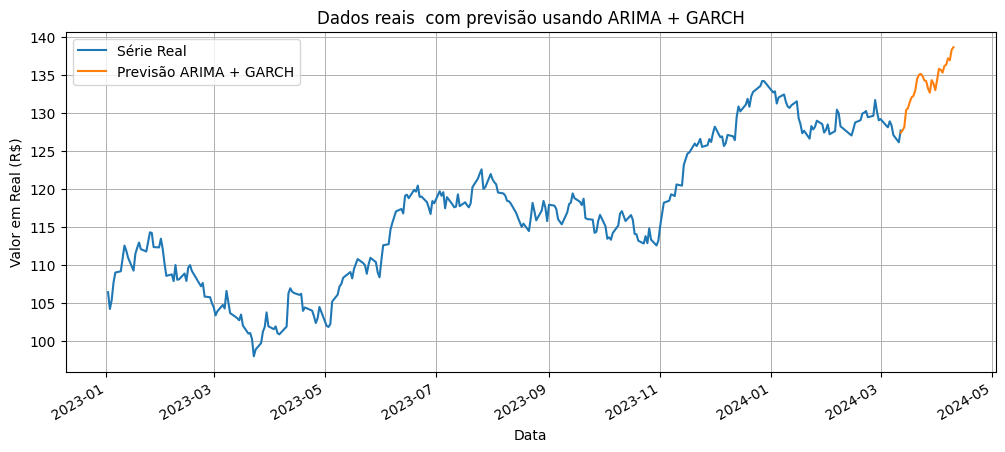

In [983]:
plotarSerie(serie_fechamento.loc[pd.Timestamp('2023-01-02'):pd.Timestamp('2024-03-12')])
plotarSerie(previsao_normal, titulo='Dados reais  com previsão usando ARIMA + GARCH', legendas=['Série Real', 'Previsão ARIMA + GARCH'])

### Avaliação do desempenho do modelo

In [984]:
dias_avaliacao = 30
treino_arima = serie_fechamento_diff.head(len(serie_fechamento_diff) - dias_avaliacao)
treino_arima.head()

Data
2004-01-05    1.087
2004-01-06    0.044
2004-01-07   -0.256
2004-01-08    0.397
2004-01-09    0.200
dtype: float64

In [985]:
test_arima = serie_fechamento_diff.tail(dias_avaliacao)
test_arima.head()

Data
2024-01-29   -0.464
2024-01-30   -1.101
2024-01-31    0.350
2024-02-01    0.729
2024-02-02   -1.299
dtype: float64

In [986]:
p,d,q =  2,1,1

modelo_arima = SARIMAX(treino_arima, order = (p,d,q), trend='c', enforce_stationarity=True)

resultado = modelo_arima.fit(maxiter=100)

print(resultado.summary())

forecast_arima = resultado.forecast(dias_avaliacao)

resid = resultado.resid
model_garch = arch.arch_model(resid, mean='Zero', vol='GARCH', p=p, q=q).fit()
forecast_garch = model_garch.forecast(horizon=dias_avaliacao)

forecast_garch
forecast = forecast_arima + np.sqrt(forecast_garch.variance.values[-1, :]) * np.random.normal(size=dias_avaliacao)
serie_prevista_garch = pd.Series(data=forecast.values, index=test_arima.index)

c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4969
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -7537.911
Date:                Sun, 13 Oct 2024   AIC                          15085.822
Time:                        17:26:15   BIC                          15118.376
Sample:                             0   HQIC                         15097.236
                               - 4969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.865e-06   1.26e-05      0.308      0.758   -2.08e-05    2.85e-05
ar.L1         -0.0703      0.005    -12.860      0.000      -0.081      -0.060
ar.L2          0.0190      0.005      3.481      0.0

c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Will\temp\fiap-tech-challenge-pos-tech-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Calculo de metricas (Erro Médio Absoluto, Erro Quadrático Médio e Erro Percentual Médio Absoluto)

* **MAE (Erro Médio Absoluto):**  Mede a média dos erros absolutos entre os valores previstos e os reais. É uma métrica robusta que não é influenciada por outliers e fornece uma ideia geral da precisão do modelo.
* **MSE (Erro Quadrático Médio):** Calcula a média dos erros ao quadrado. Penaliza mais os erros maiores, sendo útil quando grandes erros são mais problemáticos. É a base para o RMSE (raiz do erro quadrático médio), que é mais interpretado na mesma escala que os dados originais.
* **MAPE (Erro Percentual Médio Absoluto):** Calcula a média dos erros percentuais absolutos. É útil para comparar a precisão de modelos em diferentes escalas, mas pode ser instável quando há valores próximos de zero.

**Em resumo:** O MAE fornece uma medida de erro geral, o MSE penaliza mais erros grandes e o MAPE expressa o erro como uma porcentagem. A escolha da métrica depende do problema específico e da importância relativa de diferentes tipos de erros.

Para facilitar o Reuso criamos 2 métodos. Um que calcula as métricas e outro que imprime o valor das métricas com seus respectivos valores.


In [987]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(colored(f"MAE: {mae}", 'light_blue'))
    print(colored(f"MSE: {mse}", 'light_cyan'))
    print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

Foi criado uma função para salvar em memória os resultados dos testes, para no final compararmos o modelo que obteve o melhor resultado nas previsões.

In [988]:
metricas = {}

def salvar_metricas(modelo, new_metric):
    mae, mse, mape = new_metric
    m = {
        "mae": mae,
        "mse": mse,
        "mape": mape
    }
    
    metricas[modelo]=m


Para obter uma melhor métricas, iremos desfazer a diferenciação, colocando os dados na sua escala real, assim poderemos tirar melhor aproveitamento das métricas.

In [989]:
test_normalizada = reverter_diferenciacao(serie_fechamento.head(len(serie_fechamento) - dias_avaliacao),test_arima )
previsao_normalizada = reverter_diferenciacao(serie_fechamento.head(len(serie_fechamento) - dias_avaliacao),serie_prevista_garch )


In [990]:
metrics = calculate_metrics(test_normalizada.values, previsao_normalizada.values)
print_metrics(metrics)
salvar_metricas('Arima', metrics)

MAE: 5.040676133327216
MSE: 5.970191678387161
MAPE: 3.92 %


# Aplicação do modelo XGBRegressor

O **XGBRegressor** é um algoritmo de *machine learning* poderoso e eficiente, especialmente utilizado para **problemas de regressão**. Ele funciona combinando múltiplas árvores de decisão (ensemble) de forma sequencial, aprendendo dos erros dos modelos anteriores. Essa abordagem, chamada de *gradient boosting*, permite que o XGBRegressor construa modelos altamente precisos e robustos. 

Embora o XGBRegressor não tenha sido especificamente projetado para séries temporais, ele pode ser adaptado para esse tipo de problema com excelentes resultados. Isso se deve a sua capacidade de:

**Capturar padrões complexos:** As árvores de decisão do XGBoost são capazes de capturar padrões não-lineares e interações entre diferentes características, o que é comum em séries temporais.

**Lidar com grandes volumes de dados:** O algoritmo é otimizado para lidar com grandes conjuntos de dados, o que é frequentemente o caso em séries temporais.

**Alta precisão:** Em diversas competições de machine learning, o XGBoost tem demonstrado ser um dos algoritmos mais precisos.



#### Preparação dos dados

- No método abaixo estamos criando uma função para preparar os dados para o nosso modelo, separamos a data por ano, mês, dia e dia da semana e renomeamos duas colunas, 'Último' para 'valor_fechamento' e 'Abertura para valor_abertura'.

In [991]:
def create_feature(dado):
    data_frame = pd.DataFrame(dado)
    data_frame['valor_fechamento']  = data_frame['Último']
    data_frame['valor_abertura']  = data_frame['Abertura']
    data_frame['Data'] = pd.to_datetime(data_frame['Data'], format='%d.%m.%Y')
    data_frame['year'] = data_frame["Data"].dt.year
    data_frame['month'] = data_frame["Data"].dt.month
    data_frame['day'] = data_frame["Data"].dt.day
    data_frame['dayofweek'] = data_frame["Data"].dt.dayofweek
    return data_frame

Com a função criada, estabelecemos duas novas variáveis: uma chamada feature_names, que contém as variáveis que o modelo irá usar do DataFrame, e outra chamada target, que é o valor que o modelo tentará prever.

In [992]:
feature_names = ["year", "month", "day", "dayofweek","valor_abertura"]
target = "valor_fechamento"

- Em seguida, criaremos um DataFrame de features e o ordenaremos por data para preparar os dados para a divisão em conjuntos de treino e teste.

In [993]:
df_feature = create_feature(df)
df_feature = df_feature.sort_values(by='Data')
df_feature

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,valor_fechamento,valor_abertura,year,month,day,dayofweek
4999,2004-01-02,22.445,22.233,22.450,22.208,"136,42M","0,94%",22.445,22.233,2004,1,2,4
4998,2004-01-05,23.532,22.445,23.532,22.445,"496,71M","4,84%",23.532,22.445,2004,1,5,0
4997,2004-01-06,23.576,23.532,23.976,23.180,"472,38M","0,19%",23.576,23.532,2004,1,6,1
4996,2004-01-07,23.320,23.576,23.899,23.320,"464,08M","-1,09%",23.320,23.576,2004,1,7,2
4995,2004-01-08,23.717,23.334,23.718,23.122,"436,74M","1,70%",23.717,23.334,2004,1,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-03-06,128.890,128.099,129.323,128.099,"11,06M","0,62%",128.890,128.099,2024,3,6,2
3,2024-03-07,128.340,128.890,129.188,128.033,"7,35M","-0,43%",128.340,128.890,2024,3,7,3
2,2024-03-08,127.071,128.335,128.338,125.802,"11,94M","-0,99%",127.071,128.335,2024,3,8,4
1,2024-03-11,126.124,127.068,127.068,126.065,"8,90M","-0,75%",126.124,127.068,2024,3,11,0


- Com o DataFrame de features pronto, podemos dividir os dados em conjuntos de treino e teste. Utilizaremos a função **train_test_split** do scikit-learn para essa tarefa. A variável **X** conterá as features (características) que o modelo utilizará para fazer as previsões, enquanto **y** conterá o target (valor que queremos prever). Definiremos **test_size=0.0059** para que o conjunto de teste represente os últimos 30 dias dos nossos dados (considerando um DataFrame com 5000 registros). Ao configurar **shuffle=False**, garantimos que a ordem temporal dos dados seja preservada, evitando que os dados de teste 'contaminem' o conjunto de treino.

In [994]:
X = df_feature[feature_names]
y = df_feature['valor_fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0059, shuffle=False)
len(X_train), len(X_test)

(4970, 30)

Separamos treino e teste. Com isso, temos 4970 registros para teste e 30 para treino.

In [995]:
X_train.head()

,year,month,day,dayofweek,valor_abertura
4999,2004,1,2,4,22.233
4998,2004,1,5,0,22.445
4997,2004,1,6,1,23.532
4996,2004,1,7,2,23.576
4995,2004,1,8,3,23.334


Observando as 5 primeiras linhas do conjunto de treino, foi possível validar que os dados começaram em 2004, conforme esperávamos.

In [996]:
X_train.tail()

,year,month,day,dayofweek,valor_abertura
34,2024,1,22,0,127.636
33,2024,1,23,1,126.612
32,2024,1,24,2,128.275
31,2024,1,25,3,127.815
30,2024,1,26,4,128.196


Observando as 5 últimas linhas do conjunto de treino, foi possível notar que os últimos dias correspondem a janeiro de 2024, conforme o esperado.

In [997]:
X_test

,year,month,day,dayofweek,valor_abertura
29,2024,1,29,0,128.970
28,2024,1,30,1,128.492
27,2024,1,31,2,127.402
26,2024,2,1,3,127.752
25,2024,2,2,4,128.471
24,2024,2,5,0,127.182
23,2024,2,6,1,127.593
22,2024,2,7,2,130.412
21,2024,2,8,3,129.950
20,2024,2,9,4,128.216


O nosso X_test tambem ficou adequado, começando final de janeiro até dia 12 de março.

Criamos um modelo XGBRegressor configurado para minimizar o erro quadrático médio ("reg:squarederror").
- Treinamos o modelo com os dados de treino (`X_train`, `y_train`). O modelo aprende a relação entre as features (`X_train`) e o target (`y_train`).
- Utilizamos o modelo treinado para fazer previsões nos dados de teste (`X_test`). A variável `predict_values` armazena as previsões do modelo para cada ponto no conjunto de teste.
- `predict_values` contém as previsões do modelo para o target nos dados de teste, que podemos comparar com o target real para avaliar a performance do modelo.


In [998]:
reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

predict_values = reg.predict(X_test)

Com os dados já previstos, iremos calcular as métricas para entender como foi a performance do modelo.

In [999]:
metrics = calculate_metrics(y_true=predict_values, y_pred=y_test.values)
print_metrics(metrics)
salvar_metricas('XGBRegressor', metrics)

MAE: 1.6837125284830714
MSE: 2.10059402879464
MAPE: 1.32 %


O erro médio absoluto (MAE) indica que, em média, as previsões estão desviando cerca de 1.68 unidades do valor real. 

O erro quadrático médio (MSE) sugere que os erros maiores estão sendo penalizados.

O erro percentual absoluto médio (MAPE) indica um erro médio de aproximadamente 1.32%.

Agora iremos reconstruir a data da série treino para que seja possível visualizar os dados com os valores previstos.

In [1000]:
X_train["data"] = X_train["year"].map(str) + "-" + X_train["month"].map(str) + "-" + X_train["day"].map(str)
serie_treino = pd.Series(data=y_train.values, index=pd.to_datetime(X_train['data']))
serie_treino

data
2004-01-02     22.445
2004-01-05     23.532
2004-01-06     23.576
2004-01-07     23.320
2004-01-08     23.717
               ...   
2024-01-22    126.602
2024-01-23    128.263
2024-01-24    127.816
2024-01-25    128.169
2024-01-26    128.967
Length: 4970, dtype: float64

Construindo as datas dos valores previsto.

In [1001]:
X_test["data"] = X_test["year"].map(str) + "-" + X_test["month"].map(str) + "-" + X_test["day"].map(str)
serie_prevista_xgb = pd.Series(data=predict_values, index=pd.to_datetime(X_test['data']))
serie_prevista_xgb


data
2024-01-29    128.220520
2024-01-30    128.194733
2024-01-31    128.257401
2024-02-01    127.478554
2024-02-02    130.166046
2024-02-05    128.077362
2024-02-06    127.397919
2024-02-07    131.767731
2024-02-08    129.222549
2024-02-09    128.098694
2024-02-14    128.014954
2024-02-15    127.205849
2024-02-16    127.009399
2024-02-19    128.296616
2024-02-20    126.845558
2024-02-21    126.126633
2024-02-22    125.770470
2024-02-23    129.437500
2024-02-26    127.285614
2024-02-27    126.741516
2024-02-28    128.558121
2024-02-29    126.371628
2024-03-01    130.067657
2024-03-04    130.302887
2024-03-05    129.673279
2024-03-06    126.969925
2024-03-07    129.363068
2024-03-08    129.344864
2024-03-11    127.297882
2024-03-12    126.969910
dtype: float32

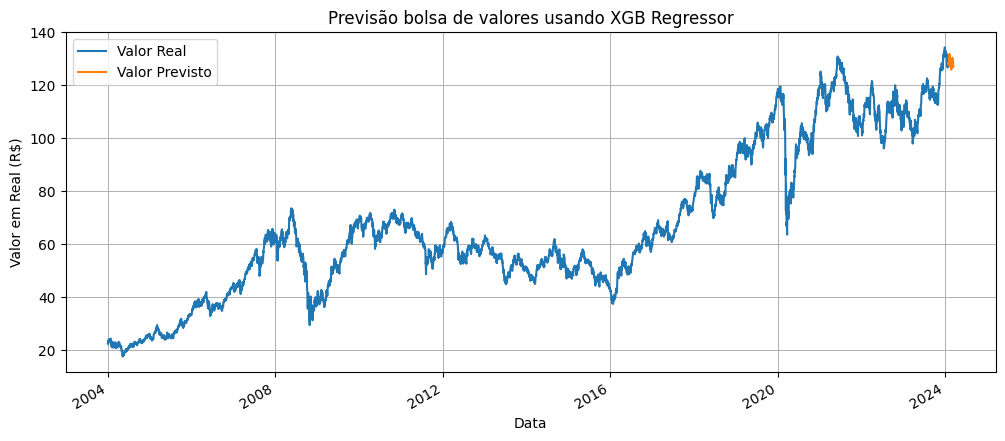

In [1002]:
plotarSerie(serie_treino)
plotarSerie(serie_prevista_xgb,titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])


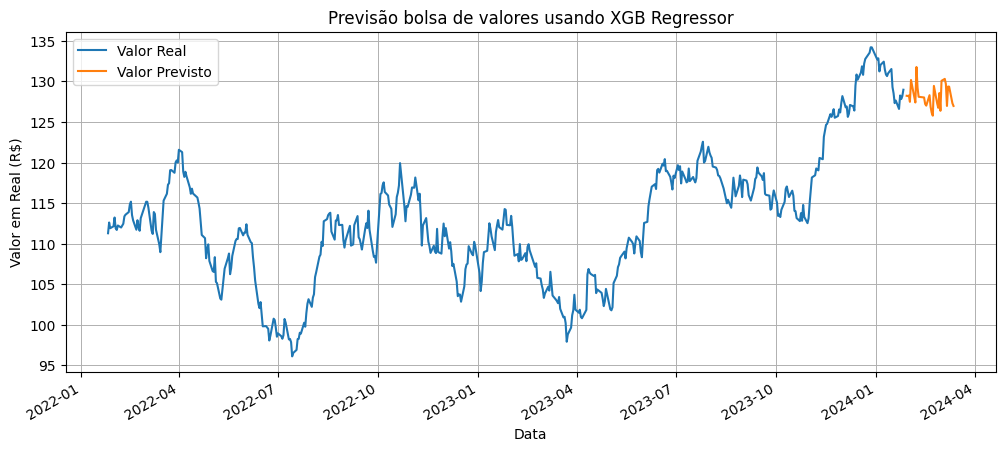

In [1003]:
plotarSerie(serie_treino[-500:])
plotarSerie(serie_prevista_xgb, titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])


# Aplicação do modelo Prophet

O **Prophet** é uma biblioteca desenvolvida pelo Facebook (agora Meta) voltada para a modelagem e previsão de **séries temporais**. Ele foi projetado para lidar com componentes sazonais, tendências e feriados de maneira intuitiva e eficiente. Uma de suas maiores vantagens é a simplicidade e a facilidade de uso, mesmo para aqueles que não possuem experiência avançada com modelagem estatística.

Prophet se destaca por:

- Ser robusto com dados ausentes.
- Gerenciar mudanças de tendência.
- Considerar sazonalidades e eventos especiais, como feriados.
- Funcionar bem com séries temporais diárias, semanais e anuais.

In [1004]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


Preparação dos dados para utilização com o modelo, mantendo somente as datas (ds) e o target y (Último):

In [1005]:
df_p = pd.DataFrame(df)
df_p['ds'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df_p.head()


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,ds
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%",2024-03-12
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%",2024-03-11
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%",2024-03-08
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%",2024-03-07
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%",2024-03-06


In [1006]:
df_p.rename(columns={'Último':'y'}, inplace=True)
df_p

,Data,y,Abertura,Máxima,Mínima,Vol.,Var%,ds
0,12.03.2024,127.668,126.124,128.039,126.121,"9,48M","1,22%",2024-03-12
1,11.03.2024,126.124,127.068,127.068,126.065,"8,90M","-0,75%",2024-03-11
2,08.03.2024,127.071,128.335,128.338,125.802,"11,94M","-0,99%",2024-03-08
3,07.03.2024,128.340,128.890,129.188,128.033,"7,35M","-0,43%",2024-03-07
4,06.03.2024,128.890,128.099,129.323,128.099,"11,06M","0,62%",2024-03-06
...,...,...,...,...,...,...,...,...
4995,08.01.2004,23.717,23.334,23.718,23.122,"436,74M","1,70%",2004-01-08
4996,07.01.2004,23.320,23.576,23.899,23.320,"464,08M","-1,09%",2004-01-07
4997,06.01.2004,23.576,23.532,23.976,23.180,"472,38M","0,19%",2004-01-06
4998,05.01.2004,23.532,22.445,23.532,22.445,"496,71M","4,84%",2004-01-05


In [1007]:
df_p = df_p[['ds', 'y']]

In [1008]:
df_p = df_p.sort_values(by='ds')
df_p

,ds,y
4999,2004-01-02,22.445
4998,2004-01-05,23.532
4997,2004-01-06,23.576
4996,2004-01-07,23.320
4995,2004-01-08,23.717
...,...,...
4,2024-03-06,128.890
3,2024-03-07,128.340
2,2024-03-08,127.071
1,2024-03-11,126.124


Prevendo os feriados do estado de São Paulo.

In [1009]:
sp_feriados = holidays.Brazil(state='SP')
def preve_feriado(data):
    data_formatada = data.strftime('%Y-%m-%d')    
    return data_formatada in sp_feriados

In [1010]:

df_p['dias_uteis'] = df_p['ds'].dt.dayofweek < 5 
df_p['feriados'] = df_p['ds'].map(preve_feriado)

Realizando a divisão dos dados em treino e teste, utilizando o SKLearn:

In [1011]:

treino, teste = train_test_split(df_p, test_size=0.0059, shuffle=False)



In [1012]:
treino

,ds,y,dias_uteis,feriados
4999,2004-01-02,22.445,True,False
4998,2004-01-05,23.532,True,False
4997,2004-01-06,23.576,True,False
4996,2004-01-07,23.320,True,False
4995,2004-01-08,23.717,True,False
...,...,...,...,...
34,2024-01-22,126.602,True,False
33,2024-01-23,128.263,True,False
32,2024-01-24,127.816,True,False
31,2024-01-25,128.169,True,False


In [1013]:
teste

,ds,y,dias_uteis,feriados
29,2024-01-29,128.503,True,False
28,2024-01-30,127.402,True,False
27,2024-01-31,127.752,True,False
26,2024-02-01,128.481,True,False
25,2024-02-02,127.182,True,False
24,2024-02-05,127.593,True,False
23,2024-02-06,130.416,True,False
22,2024-02-07,129.950,True,False
21,2024-02-08,128.217,True,False
20,2024-02-09,128.026,True,False


Treinando o modelo comos dados até o dia 26/01/2024, com sazonalidade diária:

In [1014]:
modelo_prop = Prophet(daily_seasonality=True)
modelo_prop.add_regressor("dias_uteis")
modelo_prop.add_regressor("feriados")
modelo_prop.fit(treino)

17:26:19 - cmdstanpy - INFO - Chain [1] start processing
17:26:25 - cmdstanpy - INFO - Chain [1] done processing


Ajustando os períodos a serem previstos conforme o tamanho do dataframe de testes, e configurando a coluna booleana de feriados:

In [1015]:
future_prop = modelo_prop.make_future_dataframe(periods=len(teste))
future_prop

,ds
0,2004-01-02
1,2004-01-05
2,2004-01-06
3,2004-01-07
4,2004-01-08
...,...
4995,2024-02-21
4996,2024-02-22
4997,2024-02-23
4998,2024-02-24


In [1016]:
future_prop['dias_uteis'] = df_p['dias_uteis']
future_prop['feriados'] = df_p['feriados']
future_prop

,ds,dias_uteis,feriados
0,2004-01-02,True,False
1,2004-01-05,True,False
2,2004-01-06,True,False
3,2004-01-07,True,False
4,2004-01-08,True,False
...,...,...,...
4995,2024-02-21,True,False
4996,2024-02-22,True,False
4997,2024-02-23,True,False
4998,2024-02-24,True,False


Realizando a previsão:

In [1017]:
forecast_prop = modelo_prop.predict(future_prop)
forecast_prop

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-02,21.697425,12.703701,28.224859,21.697425,21.697425,-1.531735,-1.531735,-1.531735,-2.223557,...,-0.083400,-0.083400,-0.083400,1.331111,1.331111,1.331111,0.0,0.0,0.0,20.165690
1,2004-01-05,21.747257,12.711257,28.123584,21.747257,21.747257,-1.345541,-1.345541,-1.345541,-2.223557,...,-0.159944,-0.159944,-0.159944,1.593850,1.593850,1.593850,0.0,0.0,0.0,20.401716
2,2004-01-06,21.763868,12.775033,29.037575,21.763868,21.763868,-1.231840,-1.231840,-1.231840,-2.223557,...,-0.127033,-0.127033,-0.127033,1.674639,1.674639,1.674639,0.0,0.0,0.0,20.532027
3,2004-01-07,21.780478,12.763256,27.620538,21.780478,21.780478,-1.131245,-1.131245,-1.131245,-2.223557,...,-0.101846,-0.101846,-0.101846,1.750047,1.750047,1.750047,0.0,0.0,0.0,20.649234
4,2004-01-08,21.797089,12.948760,28.896904,21.797089,21.797089,-1.044135,-1.044135,-1.044135,-2.223557,...,-0.083667,-0.083667,-0.083667,1.818978,1.818978,1.818978,0.0,0.0,0.0,20.752954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2024-02-21,121.579947,112.422211,128.661517,121.579947,121.579947,-1.030967,-1.030967,-1.030967,-2.223557,...,-0.101846,-0.101846,-0.101846,1.850325,1.850325,1.850325,0.0,0.0,0.0,120.548981
4996,2024-02-22,121.590522,112.080299,128.150899,121.590522,121.590522,-1.042719,-1.042719,-1.042719,-2.223557,...,-0.083667,-0.083667,-0.083667,1.820394,1.820394,1.820394,0.0,0.0,0.0,120.547803
4997,2024-02-23,121.601097,112.194363,128.422579,121.601097,121.601097,-1.086133,-1.086133,-1.086133,-2.223557,...,-0.083400,-0.083400,-0.083400,1.776713,1.776713,1.776713,0.0,0.0,0.0,120.514965
4998,2024-02-24,121.611672,112.406420,128.029731,121.611672,121.611672,-0.782479,-0.782479,-0.782479,-2.223557,...,0.277945,0.277945,0.277945,1.719022,1.719022,1.719022,0.0,0.0,0.0,120.829193


In [1018]:
predito_prop = forecast_prop.tail(len(teste))[["ds",'yhat']]
predito_prop.rename(columns={'ds':'data_prevista'}, inplace=True)
predito_prop

,data_prevista,yhat
4970,2024-01-27,120.395758
4971,2024-01-28,120.359149
4972,2024-01-29,119.889641
4973,2024-01-30,119.897000
4974,2024-01-31,119.903613
4975,2024-02-01,119.910914
4976,2024-02-02,119.908511
4977,2024-02-03,120.275677
4978,2024-02-04,120.290036
4979,2024-02-05,119.874852


Criação de um dataframe com os dados de teste e previstos:

In [1019]:
novo_df = pd.DataFrame(teste)
novo_df['previsto'] = predito_prop['yhat'].values
novo_df

,ds,y,dias_uteis,feriados,previsto
29,2024-01-29,128.503,True,False,120.395758
28,2024-01-30,127.402,True,False,120.359149
27,2024-01-31,127.752,True,False,119.889641
26,2024-02-01,128.481,True,False,119.897000
25,2024-02-02,127.182,True,False,119.903613
24,2024-02-05,127.593,True,False,119.910914
23,2024-02-06,130.416,True,False,119.908511
22,2024-02-07,129.950,True,False,120.275677
21,2024-02-08,128.217,True,False,120.290036
20,2024-02-09,128.026,True,False,119.874852


Cálculo das métricas de desempenho:

In [1020]:
metrics = calculate_metrics(y_true=teste['y'].values, y_pred=novo_df['previsto'])
print_metrics(metrics)
salvar_metricas('Prophet', metrics)

MAE: 8.338262139101852
MSE: 8.428048389430458
MAPE: 6.47 %


Esses valores sugerem que o modelo está apresentando um bom desempenho. Uma previsão com MAPE abaixo de 10% já pode ser considerada muito boa em muitos contextos, especialmente em séries temporais voláteis, como a de índices financeiros. O MAE relativamente baixo também sugere que o modelo está realizando previsões com uma margem de erro considerável para aplicações práticas.

In [1021]:
forecast_prop['yhat_upper'].values
forecast_prop['yhat_lower'].values

array([ 12.70370117,  12.71125663,  12.77503305, ..., 112.19436259,
       112.40642033, 113.1943189 ])

Criação de dataframe com valor real, previsto (yhat), e intervalos de confiança (yhat_lower e yhat_upper):

In [1022]:
resultado_final  = { 
                    'valor_real': df_p['y'].values, 
                    'valor_previsto': forecast_prop['yhat'].values, 
                    'valor_previsao_maxima': forecast_prop['yhat_upper'].values, 
                    'valor_previsao_minima': forecast_prop['yhat_lower'].values
                    }

df_resultado  = pd.DataFrame(data=resultado_final, index=df_p['ds'])
df_resultado

,valor_real,valor_previsto,valor_previsao_maxima,valor_previsao_minima
ds,,,,
2004-01-02,22.445,20.165690,28.224859,12.703701
2004-01-05,23.532,20.401716,28.123584,12.711257
2004-01-06,23.576,20.532027,29.037575,12.775033
2004-01-07,23.320,20.649234,27.620538,12.763256
2004-01-08,23.717,20.752954,28.896904,12.948760
...,...,...,...,...
2024-03-06,128.890,120.548981,128.661517,112.422211
2024-03-07,128.340,120.547803,128.150899,112.080299
2024-03-08,127.071,120.514965,128.422579,112.194363


**Gráficos:** 

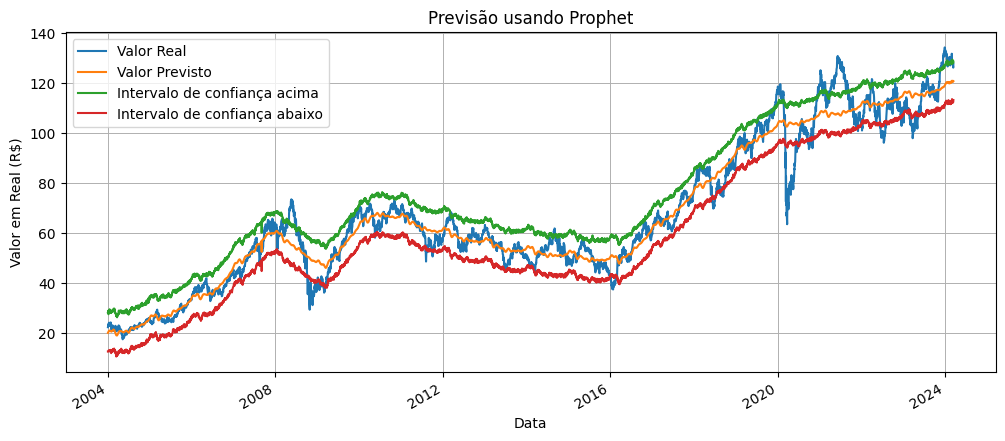

In [1023]:
plotarSerie(df_resultado['valor_real'])
plotarSerie(df_resultado['valor_previsto'])
plotarSerie(df_resultado['valor_previsao_maxima'])
plotarSerie(df_resultado['valor_previsao_minima'],titulo="Previsão usando Prophet", legendas=['Valor Real', 'Valor Previsto', 'Intervalo de confiança acima', 'Intervalo de confiança abaixo'])

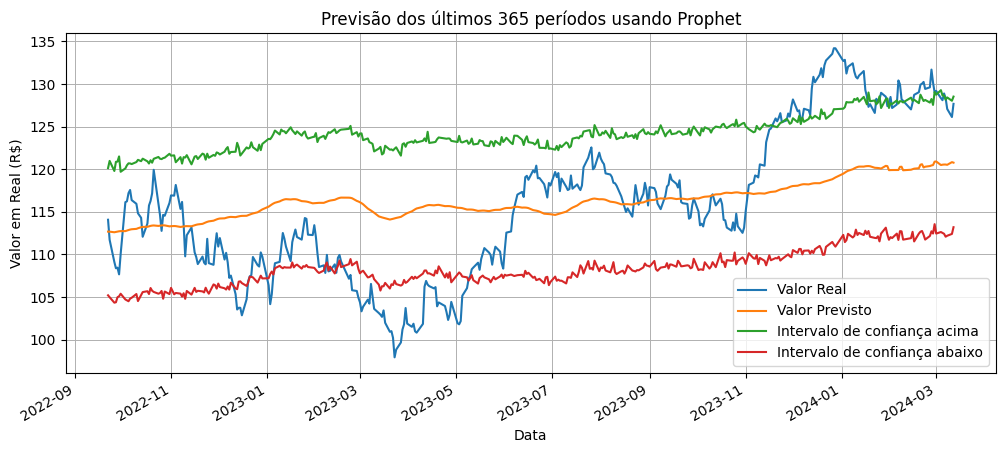

In [1024]:
plotarSerie(df_resultado['valor_real'].tail(365))
plotarSerie(df_resultado['valor_previsto'].tail(365))
plotarSerie(df_resultado['valor_previsao_maxima'].tail(365))
plotarSerie(df_resultado['valor_previsao_minima'].tail(365),titulo="Previsão dos últimos 365 períodos usando Prophet", legendas=['Valor Real', 'Valor Previsto', 'Intervalo de confiança acima', 'Intervalo de confiança abaixo'])

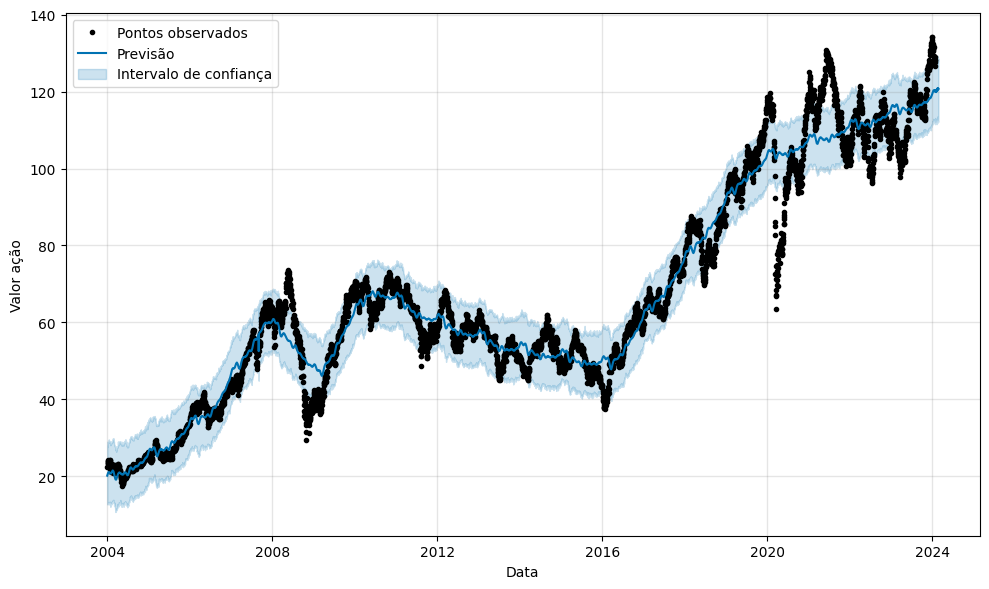

In [1025]:
modelo_prop.plot(forecast_prop)
plt.legend(loc='best', labels=['Pontos observados','Previsão', 'Intervalo de confiança'])
plt.ylabel('Valor ação')
plt.xlabel('Data')
plt.show()

# Avaliação de todos os Modelos (ARIMA, XGB Regressor e Prophet)

In [1026]:
resultado_modelos = pd.DataFrame(metricas).T
resultado_modelos.head().sort_values(by="mape", ascending=True)

,mae,mse,mape
XGBRegressor,1.683713,2.100594,1.317952
Arima,5.040676,5.970192,3.918527
Prophet,8.338262,8.428048,6.472554


## Conclusão

Após a análise dos três modelos ARIMA, Prophet e XGB Regressor, podemos concluir que o modelo XGB Regressor apresentou os melhores resultados em termos de precisão e performance. Sua capacidade de capturar padrões complexos nos dados demonstrou ser superior, proporcionando previsões mais confiáveis. Essa análise destaca a eficácia do XGB Regressor como uma ferramenta valiosa para futuras previsões.

# Extra: Aplicação do modelo XGBRegressor com maior tempo

#### Preparação dos dados

- No método abaixo estamos criando uma função para preparar os dados para o nosso modelo, separamos a data por ano, mês, dia e dia da semana, e renomeamos duas colunas 'Último' para 'valor_fechamento' e 'Abertura' para 'valor_abertura'

In [1027]:
def create_feature(dado):
    data_frame = pd.DataFrame(dado)
    data_frame['valor_fechamento']  = data_frame['Último']
    data_frame['valor_abertura']  = data_frame['Abertura']
    data_frame['Data'] = pd.to_datetime(data_frame['Data'], format='%d.%m.%Y')
    data_frame['year'] = data_frame["Data"].dt.year
    data_frame['month'] = data_frame["Data"].dt.month
    data_frame['day'] = data_frame["Data"].dt.day
    data_frame['dayofweek'] = data_frame["Data"].dt.dayofweek
    return data_frame

Com a função criada, criamos duas novas variáveis, que é o feature_names no qual será as variáveis que o modelo irá usar do dataframe e o target, que é o valor que o modelo tentará prever.

In [1028]:
feature_names = ["year", "month", "day", "dayofweek"]
target = "valor_fechamento"

- Em seguida, criaremos um DataFrame de features e o ordenaremos por data para preparar os dados para a divisão em conjuntos de treino e teste.

In [1029]:
df_feature = create_feature(df)
df_feature = df_feature.sort_values(by='Data')
df_feature

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,valor_fechamento,valor_abertura,year,month,day,dayofweek
4999,2004-01-02,22.445,22.233,22.450,22.208,"136,42M","0,94%",22.445,22.233,2004,1,2,4
4998,2004-01-05,23.532,22.445,23.532,22.445,"496,71M","4,84%",23.532,22.445,2004,1,5,0
4997,2004-01-06,23.576,23.532,23.976,23.180,"472,38M","0,19%",23.576,23.532,2004,1,6,1
4996,2004-01-07,23.320,23.576,23.899,23.320,"464,08M","-1,09%",23.320,23.576,2004,1,7,2
4995,2004-01-08,23.717,23.334,23.718,23.122,"436,74M","1,70%",23.717,23.334,2004,1,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2024-03-06,128.890,128.099,129.323,128.099,"11,06M","0,62%",128.890,128.099,2024,3,6,2
3,2024-03-07,128.340,128.890,129.188,128.033,"7,35M","-0,43%",128.340,128.890,2024,3,7,3
2,2024-03-08,127.071,128.335,128.338,125.802,"11,94M","-0,99%",127.071,128.335,2024,3,8,4
1,2024-03-11,126.124,127.068,127.068,126.065,"8,90M","-0,75%",126.124,127.068,2024,3,11,0


- Com o DataFrame de features pronto, podemos dividir os dados em conjuntos de treino e teste. Utilizaremos a função **train_test_split** do scikit-learn para essa tarefa. A variável **X** conterá as features (características) que o modelo utilizará para fazer as previsões, enquanto **y** conterá o target (valor que queremos prever). Definiremos **test_size=0.0580** para que o conjunto de teste represente os últimos 290 dias dos nossos dados (considerando um DataFrame com 5000 registros). Ao configurar **shuffle=False**, garantimos que a ordem temporal dos dados seja preservada, evitando que os dados de teste 'contaminem' o conjunto de treino.

In [1030]:
X = df_feature[feature_names]
y = df_feature['valor_fechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0580, shuffle=False)
len(X_train), len(X_test)

(4710, 290)

Separamos treino e teste e temos 4710 registros para teste e 290 para treino

In [1031]:
X_train.head()

,year,month,day,dayofweek
4999,2004,1,2,4
4998,2004,1,5,0
4997,2004,1,6,1
4996,2004,1,7,2
4995,2004,1,8,3


Observando as 5 primeiros linhas do treino foi possível validar que os dados começaram de 2004, conforme o  esperado

In [1032]:
X_train.tail()

,year,month,day,dayofweek
294,2023,1,4,2
293,2023,1,5,3
292,2023,1,6,4
291,2023,1,9,0
290,2023,1,10,1


Observando suas 5 últimas linhas do treino foi possível notar que os ultimos dias foram janeiro de 2024 conforme o esperado

In [1033]:
X_test

,year,month,day,dayofweek
289,2023,1,11,2
288,2023,1,12,3
287,2023,1,13,4
286,2023,1,16,0
285,2023,1,17,1
...,...,...,...,...
4,2024,3,6,2
3,2024,3,7,3
2,2024,3,8,4
1,2024,3,11,0


o nosso X_test também ficou adequado, começando final de janeiro até dia 12 de março

Criamos um modelo XGBRegressor configurado para minimizar o erro quadrático médio ("reg:squarederror").
- Treinamos o modelo com os dados de treino (`X_train`, `y_train`). O modelo aprende a relação entre as features (`X_train`) e o target (`y_train`).
- Utilizamos o modelo treinado para fazer previsões nos dados de teste (`X_test`). A variável `predict_values` armazena as previsões do modelo para cada ponto no conjunto de teste.
- `predict_values` contém as previsões do modelo para o target nos dados de teste, que podemos comparar com o target real para avaliar a performance do modelo.


In [1034]:
reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

predict_values = reg.predict(X_test)

Com os dados já previstos, iremos calcular as metricas para entender como foi a performance do modelo

In [1035]:
metrics = calculate_metrics(y_true=predict_values, y_pred=y_test.values)
print_metrics(metrics)
salvar_metricas('XGBRegressor', metrics)

MAE: 10.083928249806371
MSE: 12.21091471001087
MAPE: 9.03 %


O erro médio absoluto (MAE) indica que, em média, as previsões estão desviando cerca de 1.68 unidades do valor real. 

O erro quadrático médio (MSE) sugere que os erros maiores estão sendo penalizados.

O erro percentual absoluto médio (MAPE) indica um erro médio de aproximadamente 1.32%.

Agora iremos reconstruir a data da serie treino para que seja possível visualizar os dados com os valores previstos

In [1036]:
X_train["data"] = X_train["year"].map(str) + "-" + X_train["month"].map(str) + "-" + X_train["day"].map(str)
serie_treino = pd.Series(data=y_train.values, index=pd.to_datetime(X_train['data']))
serie_treino

data
2004-01-02     22.445
2004-01-05     23.532
2004-01-06     23.576
2004-01-07     23.320
2004-01-08     23.717
               ...   
2023-01-04    105.334
2023-01-05    107.641
2023-01-06    108.964
2023-01-09    109.130
2023-01-10    110.817
Length: 4710, dtype: float64

Construindo as datas dos valores previsto

In [1037]:
X_test["data"] = X_test["year"].map(str) + "-" + X_test["month"].map(str) + "-" + X_test["day"].map(str)
serie_prevista_xgb = pd.Series(data=predict_values, index=pd.to_datetime(X_test['data']))
serie_prevista_xgb


data
2023-01-11    111.076202
2023-01-12    111.597763
2023-01-13    111.280769
2023-01-16    110.805328
2023-01-17    111.070526
                 ...    
2024-03-06    115.436348
2024-03-07    115.685684
2024-03-08    115.681519
2024-03-11    114.885117
2024-03-12    115.330391
Length: 290, dtype: float32

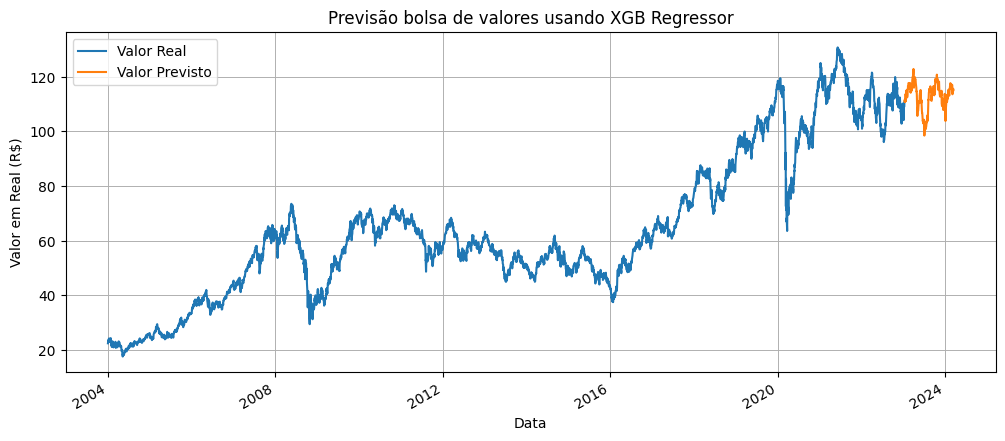

In [1038]:
plotarSerie(serie_treino)
plotarSerie(serie_prevista_xgb,titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])

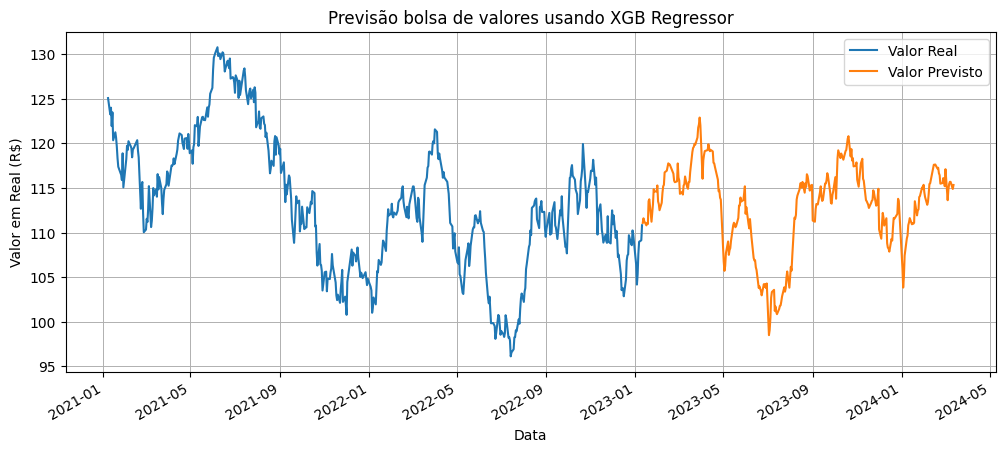

In [1039]:
plotarSerie(serie_treino[-500:])
plotarSerie(serie_prevista_xgb, titulo="Previsão bolsa de valores usando XGB Regressor", legendas=['Valor Real', 'Valor Previsto'])


- Prevendo valores de janeiro de 2024 até dezembro de 2024

#### Aqui iremos utilizar biblioteca YFINANCE do yahoo para baixar os dados da IBOVESPA, cobrimos o período de 2 de Janeiro de 2004 até 2 de Janeiro de 2024.
#### Apenas estamos demonstrando uma biblioteca que pode ser utilizada para essa finalidade, sem a necessidade de realizar o download dos dados

In [1040]:
import yfinance as yf

ticker = '^BVSP'
df_ibovespa = yf.download(ticker,start="2004-01-02",end="2024-01-02",interval="1d")

df_ibovespa

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,22233.0,22450.0,22208.0,22445.0,22445.0,0
2004-01-05,22445.0,23532.0,22445.0,23532.0,23532.0,0
2004-01-06,23532.0,23976.0,23180.0,23576.0,23576.0,0
2004-01-07,23576.0,23899.0,23320.0,23320.0,23320.0,0
2004-01-08,23334.0,23718.0,23122.0,23717.0,23717.0,0
...,...,...,...,...,...,...
2023-12-21,130826.0,132277.0,130822.0,132182.0,132182.0,8681000
2023-12-22,132553.0,133035.0,132094.0,132753.0,132753.0,8231100
2023-12-26,132753.0,133645.0,132753.0,133533.0,133533.0,0


#### Podemos observar que os valores estão em milhares, enquanto a nossa base que realizamos download estava em decimal.

### Criação de um novo dataframe para não alterar os dados originais, realizando experimentos necessários:

### Vamos então realizar a seguinte extração, fazendo o seguinte:

* data: Capturamos a data exata do índice.
* dia: Extraímos o dia do mês.
* mês: Capturamos o mês em que a negociação ocorreu.
* ano: Obtemos o ano correspondente.


##### Podemos obersavar dessa forma informações fundamentais

##### Normalizamos o valor_fechamento dividindo por 1000

##### Dessa forma a transformação é útil para facilitar a visualização e a interpretação, especialmente em grande volume de dados.

##### A outra ação foi realizar a redefinição do indice, garantindo que os dados fiquem organizados e pronto para análise posterior

##### Criando esssa função facilita a execução sempre que possível e torna o código mais limpo

In [1041]:
def create_parametros(dataframe):
    dataframe_novo = pd.DataFrame(dataframe)
    dataframe_novo['data'] = dataframe.index 
    dataframe_novo['dia'] = dataframe.index.day
    dataframe_novo['mes'] = dataframe.index.month
    dataframe_novo['ano'] = dataframe.index.year
    dataframe_novo['valor_fechamento'] = dataframe['Close'] / 1000
    dataframe_novo.reset_index(inplace=True)
    
    return dataframe_novo

In [1042]:
# Aqui chamamos a função e guardamos o resultado na variável df_feature_ibovespa
df_feature_ibovespa = create_parametros(df_ibovespa)
# Verificamos a quantidade da linhas e colunas
df_feature_ibovespa.shape

(4948, 12)

#### X -> Esse DataFrame contém as variáveis independentes, ou seja, características que iremos utilizar para prever os resultados futuros.
#### nesse contexto, como o dia, mes e ano afeta o valor de fechamento da IBOVESPA

#### y -> Esse DataFrame contém a variável dependente, ou seja, valor de fechamento normalizado da IBOVESPA, resultado que queremos prever com base nas variáveis X


### Depois dividimos os dados em conjunto de testes e treino para o modelo

In [1043]:

X = df_feature_ibovespa[['dia','mes','ano']]
y = df_feature_ibovespa['valor_fechamento']

X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.058, shuffle=False)

len(X_train), len(X_test), len(y_train), len(y_test)

(4661, 287, 4661, 287)

In [1044]:
# Observando o conjunto de treino das variáveis DIA, MÊS e ANO
X_train

,dia,mes,ano
0,2,1,2004
1,5,1,2004
2,6,1,2004
3,7,1,2004
4,8,1,2004
...,...,...,...
4656,27,10,2022
4657,28,10,2022
4658,31,10,2022
4659,1,11,2022


In [1045]:
# Observando o conjunto de teste das variáveis DIA, MÊS e ANO
X_test

,dia,mes,ano
4661,4,11,2022
4662,7,11,2022
4663,8,11,2022
4664,9,11,2022
4665,10,11,2022
...,...,...,...
4943,21,12,2023
4944,22,12,2023
4945,26,12,2023
4946,27,12,2023


In [1046]:
# Observando o conjunto de teste da variável valor_fechamento
y_test

4661    118.155
4662    115.342
4663    116.160
4664    113.580
4665    109.775
         ...   
4943    132.182
4944    132.753
4945    133.533
4946    134.194
4947    134.185
Name: valor_fechamento, Length: 287, dtype: float64

### Aplicando o Modelo e realizando as previsões com XGBoost
##### Após toda a preparação dos dados iremos realizar a verificação, minimizando o erro quadrático e treinando o modelo usando os dados de treinamento

In [1047]:

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

predict_values = reg.predict(X_test)

In [1048]:
# Realizando as previsões
predict_values

array([116.105896, 116.47923 , 115.61485 , 115.84936 , 116.12282 ,
       115.55089 , 112.53096 , 112.93671 , 113.04892 , 114.6829  ,
       116.798706, 116.40666 , 116.55314 , 117.1083  , 116.70466 ,
       115.051476, 114.268394, 114.23877 , 112.7029  , 116.318634,
       117.82128 , 117.695305, 117.875916, 117.20766 , 116.171074,
       116.58876 , 115.14585 , 114.02042 , 114.233505, 115.24846 ,
       117.07064 , 117.6417  , 118.31129 , 117.91924 , 117.24898 ,
       115.8189  , 116.701225, 116.40333 , 115.823845, 104.011345,
       103.757   , 103.37652 , 101.22368 , 101.56314 , 102.73009 ,
       102.510704, 103.654106, 105.60502 , 105.713684, 107.738434,
       106.96484 , 106.71532 , 108.11148 , 108.71325 , 108.62523 ,
       108.62523 , 110.06346 , 111.59298 , 111.8666  , 110.701996,
       112.384834, 113.51135 , 111.926285, 111.903275, 111.823715,
       111.90894 , 112.03221 , 112.20804 , 112.85198 , 114.11577 ,
       114.283066, 114.655075, 115.0256  , 113.96732 , 112.264

In [1049]:
# Observando as métricas

metricas = calculate_metrics(y_true=y_test, y_pred=predict_values)
print_metrics(metricas)

MAE: 8.466871566719295
MSE: 10.437292395943476
MAPE: 7.41 %


##### Essas métricas revelam que o modelo tem um desempenho razoável na previsão dos valores de fechamento da IBOVESPA, com um erro percentual de apenas 7.41%. 
##### Com essas informações, podemos decidir se ajustes adicionais são necessários ou se o modelo já está adequado para nossas necessidades.

In [1050]:
df_ibovespa = yf.download(ticker,start="2004-01-02",interval="1d")
df_ibovespa

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,22233.0,22450.0,22208.0,22445.0,22445.0,0
2004-01-05,22445.0,23532.0,22445.0,23532.0,23532.0,0
2004-01-06,23532.0,23976.0,23180.0,23576.0,23576.0,0
2004-01-07,23576.0,23899.0,23320.0,23320.0,23320.0,0
2004-01-08,23334.0,23718.0,23122.0,23717.0,23717.0,0
...,...,...,...,...,...,...
2024-10-07,131792.0,132943.0,131676.0,132018.0,132018.0,7702100
2024-10-08,132016.0,132016.0,130371.0,131512.0,131512.0,9093200
2024-10-09,131510.0,131520.0,129719.0,129962.0,129962.0,9220400


In [1051]:
#Aqui coleto a última data nesse dataframe
ultima_data_ibovesp = df_ibovespa.index[-1]

##### Primeiro utilizaremos a função pd.date_range para gerar uma sequência de datas, começando na última data disponíveis no dataframe, por isso guardamos em ultima_data_ibovesp


##### Consideramos apenas dias de segunda a sexta, descartando dessa forma finais de semana, porque o próprio dataframe é dessa forma.

##### Dessa forma temos uma base sólida para gerar previsões futuras do fechamento da IBOVESPA

In [1052]:
datas_futuras = pd.date_range(start=ultima_data_ibovesp, end='2024-12-30')

dia = datas_futuras.day
mes = datas_futuras.month
ano = datas_futuras.year

df_datas_futuras = pd.DataFrame(data={'dia':dia, 'mes': mes, 'ano': ano}, index=datas_futuras)

filtro_datas_uteis = df_datas_futuras.index.weekday < 5 #Peguei somente datas de segunda a sexta feira

df_datas_futuras = df_datas_futuras[filtro_datas_uteis]
df_datas_futuras.head()

,dia,mes,ano
2024-10-11,11,10,2024
2024-10-14,14,10,2024
2024-10-15,15,10,2024
2024-10-16,16,10,2024
2024-10-17,17,10,2024


In [1053]:
# Aqui chamamos a função para criar os parametros 

df_bvsp = create_parametros(df_ibovespa)

#### Após toda a preparação dos dados, com informações históricas e futuras, agora vamos realizar as previsões até o final do ano de 2024

In [1054]:
reg = xgb.XGBRegressor(objective="reg:squarederror")
X = df_bvsp[['dia','mes','ano']]
y = df_bvsp['valor_fechamento']

datas_futuras_predict = df_datas_futuras[['dia','mes','ano']]

reg.fit(X,y)

predict_values = reg.predict(datas_futuras_predict)
predict_values

array([130.52972 , 130.92381 , 131.67192 , 131.50882 , 131.51637 ,
       129.97417 , 130.04744 , 128.9159  , 127.942245, 129.33733 ,
       128.91292 , 129.4351  , 128.59799 , 128.5376  , 128.08685 ,
       130.23236 , 130.55785 , 130.38971 , 129.95769 , 130.56277 ,
       130.10043 , 129.62027 , 130.53615 , 130.94196 , 132.6242  ,
       133.06267 , 134.7073  , 134.78697 , 134.29158 , 135.0358  ,
       134.36574 , 135.56834 , 136.41144 , 136.31378 , 136.46973 ,
       135.97801 , 135.15985 , 134.22421 , 134.45546 , 133.77654 ,
       132.67162 , 129.83275 , 130.71614 , 130.40419 , 130.8434  ,
       132.29878 , 135.58359 , 135.80595 , 135.33733 , 135.46129 ,
       134.69455 , 136.0068  , 137.44069 , 138.02611 , 139.01872 ,
       139.21684 , 139.73143 ], dtype=float32)

In [1055]:
serie_previsao = pd.Series(data=predict_values, index=df_datas_futuras.index)

##### Aqui realizamos a conversão de milhares em casa decimal para melhor visualização
#### E plotamos para visualizar da melhor forma a previsão para o final do ano de 2024

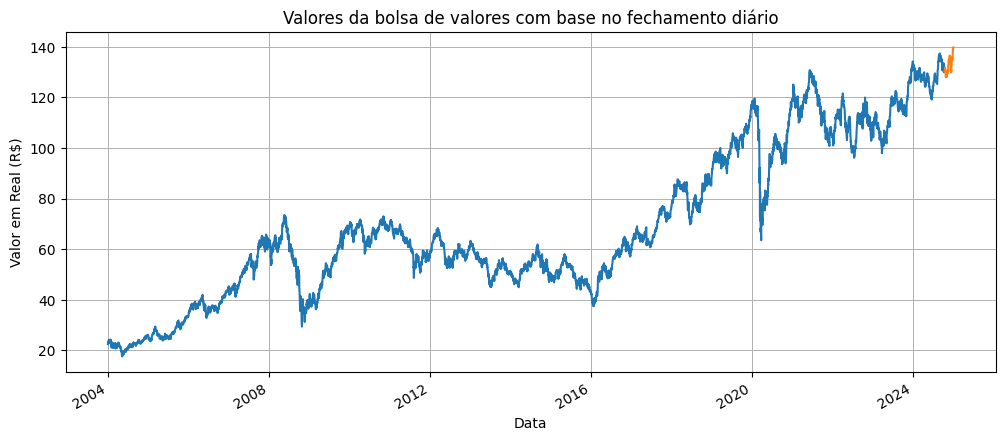

In [1056]:

dados_reais_ibovesp = df_ibovespa['Close']/1000

plotarSerie(dados_reais_ibovesp)
plotarSerie(serie_previsao)

In [1057]:
dados_reais_ibovesp.tail(500)

Date
2022-10-14    112.072
2022-10-17    113.624
2022-10-18    115.743
2022-10-19    116.274
2022-10-20    117.171
               ...   
2024-10-07    132.018
2024-10-08    131.512
2024-10-09    129.962
2024-10-10    130.353
2024-10-11    129.992
Name: Close, Length: 500, dtype: float64

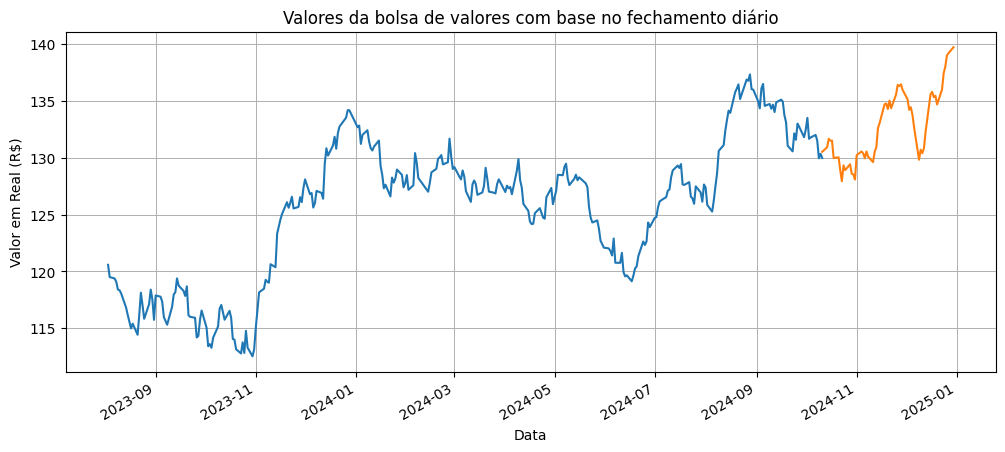

In [1058]:
plotarSerie(dados_reais_ibovesp.tail(300))
plotarSerie(serie_previsao)

Considerando apenas os 300 últimos registros

Podemos então visualizar que o modelo se comportou muito bem em relação a previsão